# Inspecting intertexts on a macro level

This code is based on https://github.com/mikekestemont/zwerfverzen/blob/main/notebooks/02-intertext-scale.ipynb

## Loading in the needed libraries 

In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display
import plotly.express as px

## Loading in data and metadata

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

id  \
49   derde_martijn                             
206  sinte_kunera                              
59   esopet                                    
235  spiegel_historiael__4_velthem__fragm_we   
48   der_ystorien_bloeme                       
191  roman_van_caesar_fragm_br                 
247  truwanten                                 
60   vanden_vier_vingheren_ende_vanden_dume    
70   Floyris ende Blantseflur                  
65   florigout_fragm_l                         

                                                 title                author  \
49   Derde Martijn                                      Jacob van Maerlant     
206  Sinte Kunera                                       NaN                    
59   Esopet                                             Calfstaf en Noydekin   
235  Spiegel historiael (P4)                            Lodewijk van Velthem   
48   Der ystorien bloeme                                NaN                    
191  Roman van Caesar                                   NaN                    
247  Truwanten                                          NaN                    
60   Expositie vanden viere vingheren ende vanden dume  NaN                    
70   Floyris ende Blantseflur                           NaN                    
65   Florigout                                          NaN                    

    provenance date_range      genre        subgenre exclude  
49   cdrom-mnl  1380-1425  Lyriek     NaN             NaN     
206  cdrom-mnl  1400-1500  Epiek      Heiligenleven   NaN     
59   cdrom-mnl  1340-1360  Epiek      Dier            NaN     
235  cdrom-mnl  1393-1402  Epiek      Historiografie  NaN     
48   cdrom-mnl  1340-1360  Epiek      Historiografie  NaN     
191  cdrom-mnl  1300-1350  Epiek      Ridder          NaN     
247  cdrom-mnl  1400-1420  Dramatiek  NaN             NaN     
60   cdrom-mnl  1400-1420  Epiek      Didactiek       NaN     
70   CG1        1225-1201  Epiek      Ridder          NaN     
65   cdrom-mnl  1375-1400  Epiek      Ridder          NaN

In [3]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
def parse_xml(fn, rm_interpol=False, rm_prose=True):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
       
    if rm_prose:
        for prose in tree.xpath("//prose"):
            prose.getparent().remove(prose)
        
    for line_node in tree.iterfind('.//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text if l.text is not None else '' for l in line_node.iterfind('.//lemma')] # changed this so that 'None' --> empty str
        pos_tags = [p.text if p.text is not None else '' for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'NOU-P':
                        lemmas_.append('NOU-P')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [5]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml_galahad_BY-split/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|█████████████████████████████████████████| 208/208 [00:25<00:00,  8.18it/s]


In [6]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']

In [7]:
df

title  \
0       AB recht ende averecht   
1       AB recht ende averecht   
2       AB recht ende averecht   
3       AB recht ende averecht   
4       AB recht ende averecht   
...                        ...   
873640  Wrake van Ragisel        
873641  Wrake van Ragisel        
873642  Wrake van Ragisel        
873643  Wrake van Ragisel        
873644  Wrake van Ragisel        

                                                                               tokens  \
0       Aensiet dese vrouwen hoe si gaen / Besiet hoe haer tuten staen                  
1       Besiet hoe haer tuten staen / Claer dat si hen blanketten                       
2       Claer dat si hen blanketten / Die cleeder soe lanc dat si hen letten            
3       Die cleeder soe lanc dat si hen letten / Ende sleypen hen nae al op die eerde   
4       Ende sleypen hen nae al op die eerde / Fi diere vuylder hoverde                 
...                                                                 ...                 
873640  Nu selewi swigen van desen / Ende van enen jongelinc vord lesen                 
873641  Ende van enen jongelinc vord lesen / Die te hove nu sal comen                   
873642  Die te hove nu sal comen / Eest alsict hebbe vernomen                           
873643  Eest alsict hebbe vernomen / Soe salmen noch van hem sien                       
873644  Soe salmen noch van hem sien / Groet wonder hier na gescien                     

                                                                         lemmas  \
0       aanzien deze vrouw hoe zij gaan / bezien hoe haar tuut staan              
1       bezien hoe haar tuut staan / klaar dat zij zij blanketten                 
2       klaar dat zij zij blanketten / die kleed zo lang dat zij zij letten       
3       die kleed zo lang dat zij zij letten / en slepen zij na al op die aarde   
4       en slepen zij na al op die aarde / fi die vuil hovaart                    
...                                                        ...                    
873640  nu zullen wij zwijgen van deze / en van een jongeling voort lezen         
873641  en van een jongeling voort lezen / die te hof nu zullen komen             
873642  die te hof nu zullen komen / zijn het als zij hebben vernemen             
873643  zijn het als zij hebben vernemen / zo zullen men nog van hij zien         
873644  zo zullen men nog van hij zien / groot wonder hier na geschieden          

       intertext  
0       None      
1       None      
2       None      
3       None      
4       None      
...      ...      
873640  None      
873641  None      
873642  None      
873643  None      
873644  None      

[873645 rows x 4 columns]

In [8]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            words = verse.strip().split()
            if words:  # Check if the list is not empty
                rhymes.append(words[-1])
            else:
                rhymes.append('')  # Append an empty string if no words
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

df = add_rhyme_column(df)

In [9]:
optim_vs = 9000
optim_rw = 0.1693877551020408
optim_th = 0.4217159759743446

rolling_size = 1000

In [10]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

## Utility functions

In [11]:
def batch(iterable, n=1):
    l = iterable.shape[0]
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def pairwise(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = None

    for ax in batch(AX, batch_size):
        if all_distances is None:
            all_distances = pairwise_distances(ax, BX, metric='cosine')
        else:
            all_distances = np.append(all_distances,
                                      pairwise_distances(ax, BX, metric='cosine'),
                                      axis=0)
    
    return all_distances

In [12]:
def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax, color='darkblue') # poster: '#c22837')
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [13]:
def plot_intertexts(t1, t2, distances, threshold):
    x, y, sizes = [], [], []
    min_raw_sim, max_raw_sim = float('inf'), float('-inf')

    for i, dist in enumerate(distances):
        min_dist = dist.min()  # Get the minimum distance from this row
        if min_dist < threshold:
            # Calculate raw similarity
            raw_similarity = 1 - min_dist
            
            # Scaling for visualization
            scaled_similarity = raw_similarity ** 3  
            scaled_size = max(scaled_similarity * 200, 10)  # Avoid zero-size dots
            
            x.append(i)
            y.append(np.argmin(dist))  # Index of the minimum distance
            sizes.append(scaled_size)  # Adjust size
            
            # Track raw similarity for legend
            min_raw_sim = min(min_raw_sim, raw_similarity)
            max_raw_sim = max(max_raw_sim, raw_similarity)

    plt.figure(figsize=(10, 7))
    ax = plt.gca()  # Get the current axis
    scatter = plt.scatter(x, y, s=sizes, alpha=0.2, edgecolors='w', color='darkblue')

    # Create a legend for min and max raw similarity
    legend_handles = [
        plt.scatter([], [], s=max(min_raw_sim ** 3 * 200, 10), alpha=0.5, edgecolors='w', label=f'Min similarity: {min_raw_sim:.2f}', color='darkblue'),
        plt.scatter([], [], s=max(max_raw_sim ** 3 * 200, 10), alpha=0.5, edgecolors='w', label=f'Max similarity: {max_raw_sim:.2f}', color='darkblue')
    ]
    plt.legend(handles=legend_handles, title='Similarity', loc='lower right')
    
    # Adjust frame and ticks for better contrast
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel(t1)
    plt.ylabel(t2)
    plt.title(f'Intertexts between {t1} and {t2}')
    plt.show()

In [14]:
def plot_intertexts_colour(t1, t2, distances, threshold):
    x, y, sizes = [], [], []
    min_raw_sim, max_raw_sim = float('inf'), float('-inf')

    for i, dist in enumerate(distances):
        min_dist = dist.min()  # Get the minimum distance from this row
        if min_dist < threshold:
            # Calculate raw similarity
            raw_similarity = 1 - min_dist
            
            # Aggressive scaling for visualization
            scaled_similarity = raw_similarity ** 3  
            scaled_size = max(scaled_similarity * 200, 10)  # Avoid zero-size dots
            
            x.append(i)
            y.append(np.argmin(dist))  # Index of the minimum distance
            sizes.append(scaled_size)  # Adjust size
            
            # Track raw similarity for legend
            min_raw_sim = min(min_raw_sim, raw_similarity)
            max_raw_sim = max(max_raw_sim, raw_similarity)

    plt.figure(figsize=(10, 7), facecolor='#feecd1')
    ax = plt.gca()  # Get the current axis
    ax.set_facecolor('#fff4dc')
    scatter = plt.scatter(x, y, s=sizes, alpha=0.2, edgecolors='w', color='darkblue')

    # Create a custom legend for min and max raw similarity
    # Create a custom legend for min and max raw similarity
    legend_handles = [
        plt.scatter([], [], s=max(min_raw_sim ** 3 * 200, 10), color='darkblue', alpha=0.5, edgecolors='w', label=f'Min similarity: {min_raw_sim:.2f}'),
        plt.scatter([], [], s=max(max_raw_sim ** 3 * 200, 10), color='darkblue', alpha=0.5, edgecolors='w', label=f'Max similarity: {max_raw_sim:.2f}')
    ]
    plt.legend(handles=legend_handles, title='Similarity', loc='lower right')
    
    # Adjust frame and ticks for better contrast
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    plt.xlabel(t1)
    plt.ylabel(t2)
    plt.title(f'Intertexts between {t1} and {t2}', fontsize=16)
    plt.show()

In [15]:
def plot_intertexts_interactable(t1, t2, distances, threshold):
    x, y, sizes, hover_texts = [], [], [], []

    for i, dist in enumerate(distances):
        min_dist = dist.min()
        if min_dist < threshold:
            raw_similarity = 1 - min_dist
            scaled_similarity = raw_similarity ** 3
            scaled_size = max(scaled_similarity * 30, 1)
            
            verse1 = df.loc[df['title'] == t1].iloc[i]['tokens']
            verse2 = df.loc[df['title'] == t2].iloc[np.argmin(dist)]['tokens']
            hover_text = f"{t1}: {verse1}<br>{t2}: {verse2}"
            
            x.append(i)
            y.append(np.argmin(dist))
            sizes.append(scaled_size)
            hover_texts.append(hover_text)

    plot_df = pd.DataFrame({'x': x, 'y': y, 'size': sizes, 'verse_pair': hover_texts})

    fig = px.scatter(
        plot_df,
        x='x', y='y',
        size='size', size_max=12,
        opacity=0.4, color_discrete_sequence=['darkblue'],
        labels={'x': t1, 'y': t2},
        title=f'Intertexts between {t1} and {t2}'
    )

    fig.update_traces(
        marker=dict(line=dict(width=1, color='white')),
        hovertemplate='<b>Verse Pair:</b><br>%{customdata}<extra></extra>',
        customdata=plot_df['verse_pair']
    )

    fig.update_layout(
        width=850,
        height=600
    )

    fig.show()

In [16]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml_galahad_BY-split/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])      
    return interpol_idxs, interpol_names

## Case studies

### Brabantsche yeesten (B5) and Van den derden Eduwaert 

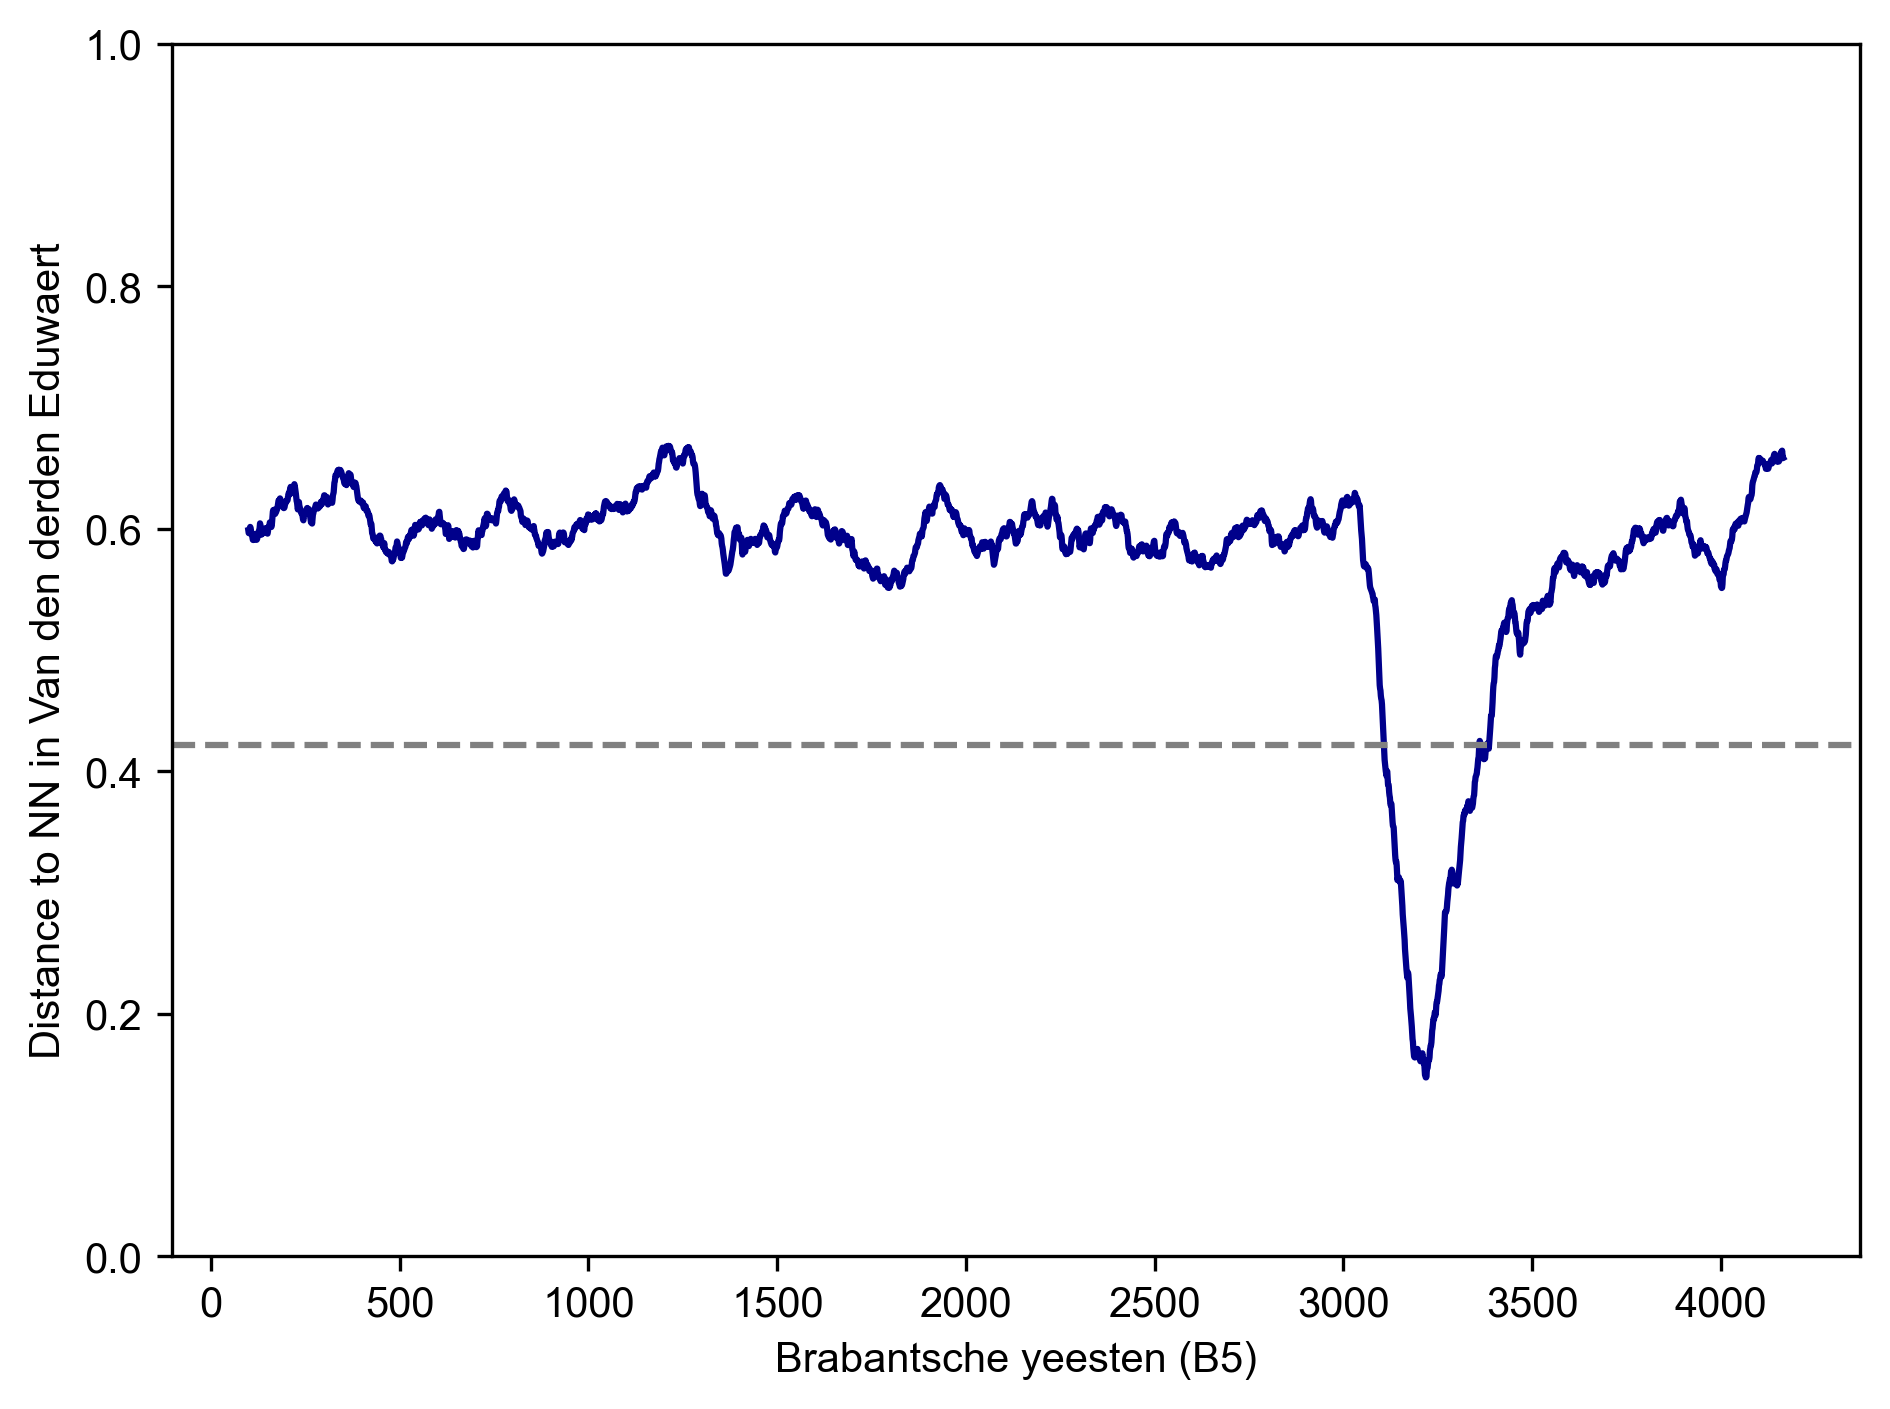

In [17]:
t1, t2 = 'Brabantsche yeesten (B5)', 'Van den derden Eduwaert'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)

plt.tight_layout()

Cosine distance for every verse pair to their neigherst neighbour. The drop points at an intertextual passage.

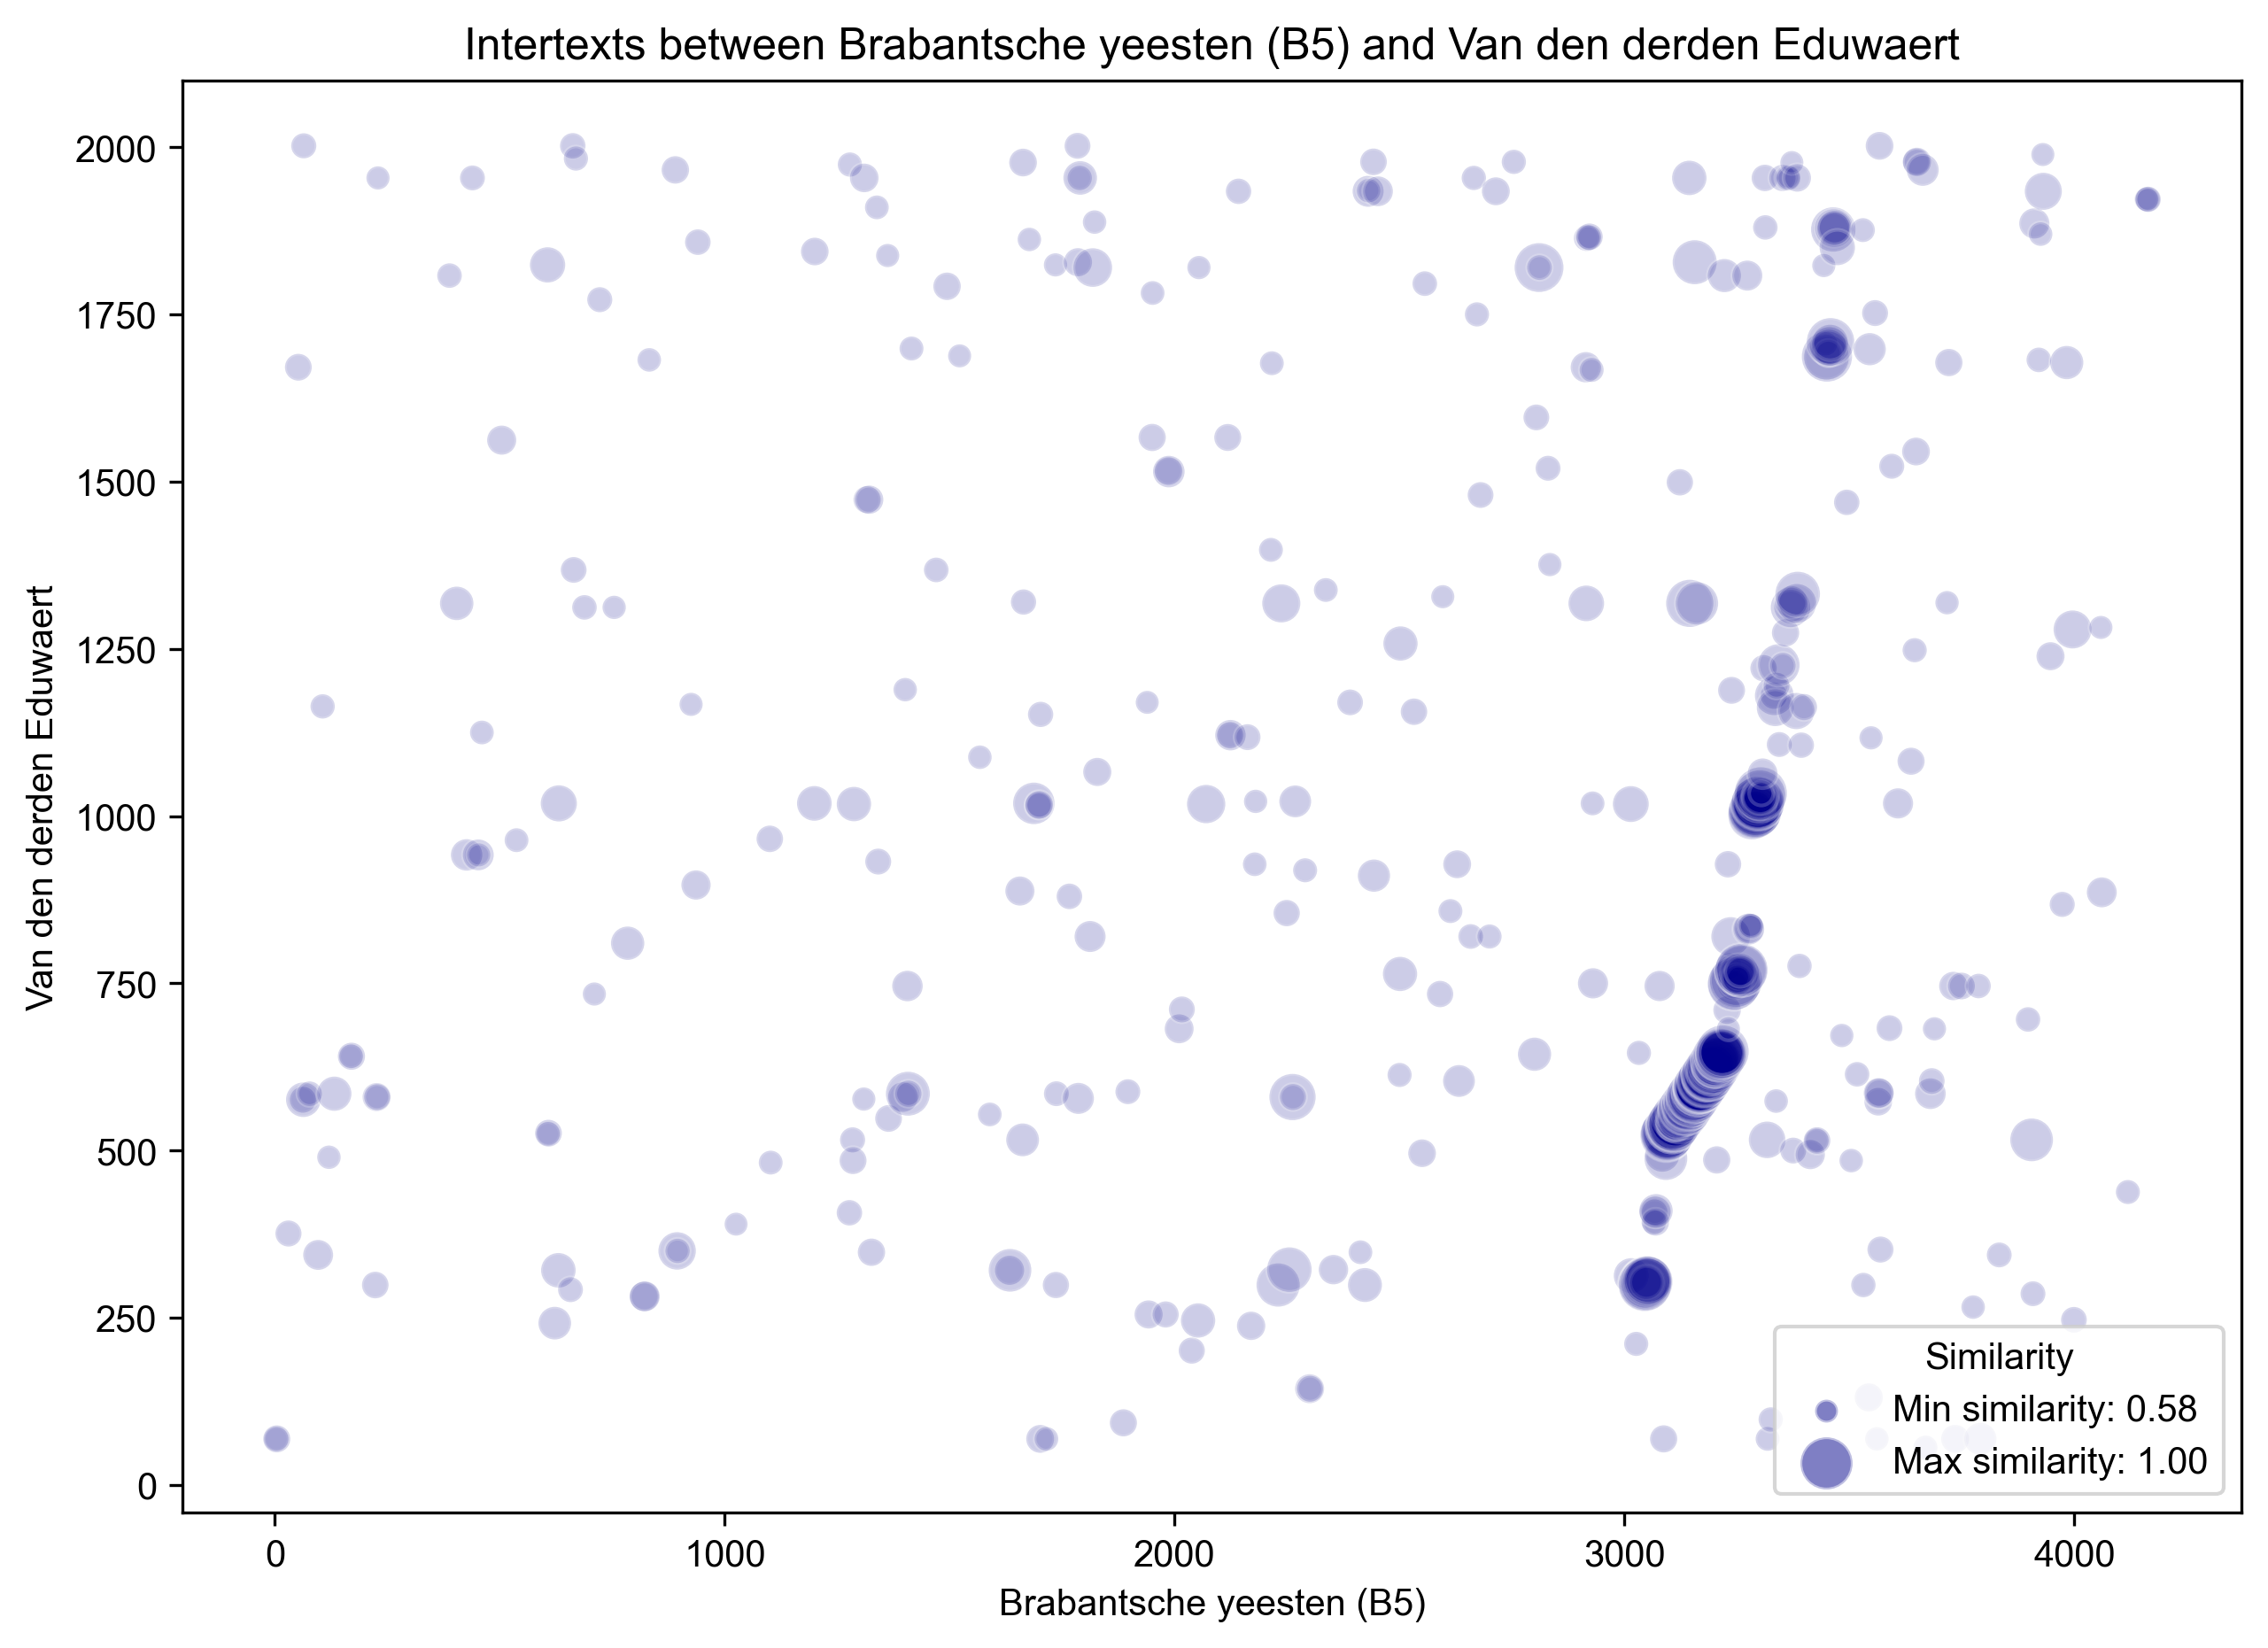

In [18]:
plot_intertexts(t1, t2, distances, threshold=optim_th)

All the dots are neigherst neighbours verse pairs that are above the optim_th. The verse NN pairs below optim_th are not included. The bigger the dot, the larger the cosine similarity between the verse pairs. You can see some scattering, this can point at 
1) Coincidental intertexts (maybe because the texts share the same author?)
2) Mismatches by our calculation

The interesting dots are the 'trains', there you can see that certain passages include many identical, shared versions between the text, after one another: a shared passage.

In [19]:
plot_intertexts_interactable(t1, t2, distances, threshold=optim_th)

Same plot as before but after running the cell you can hover over the dots and see the parallel verses.

### Vice versa

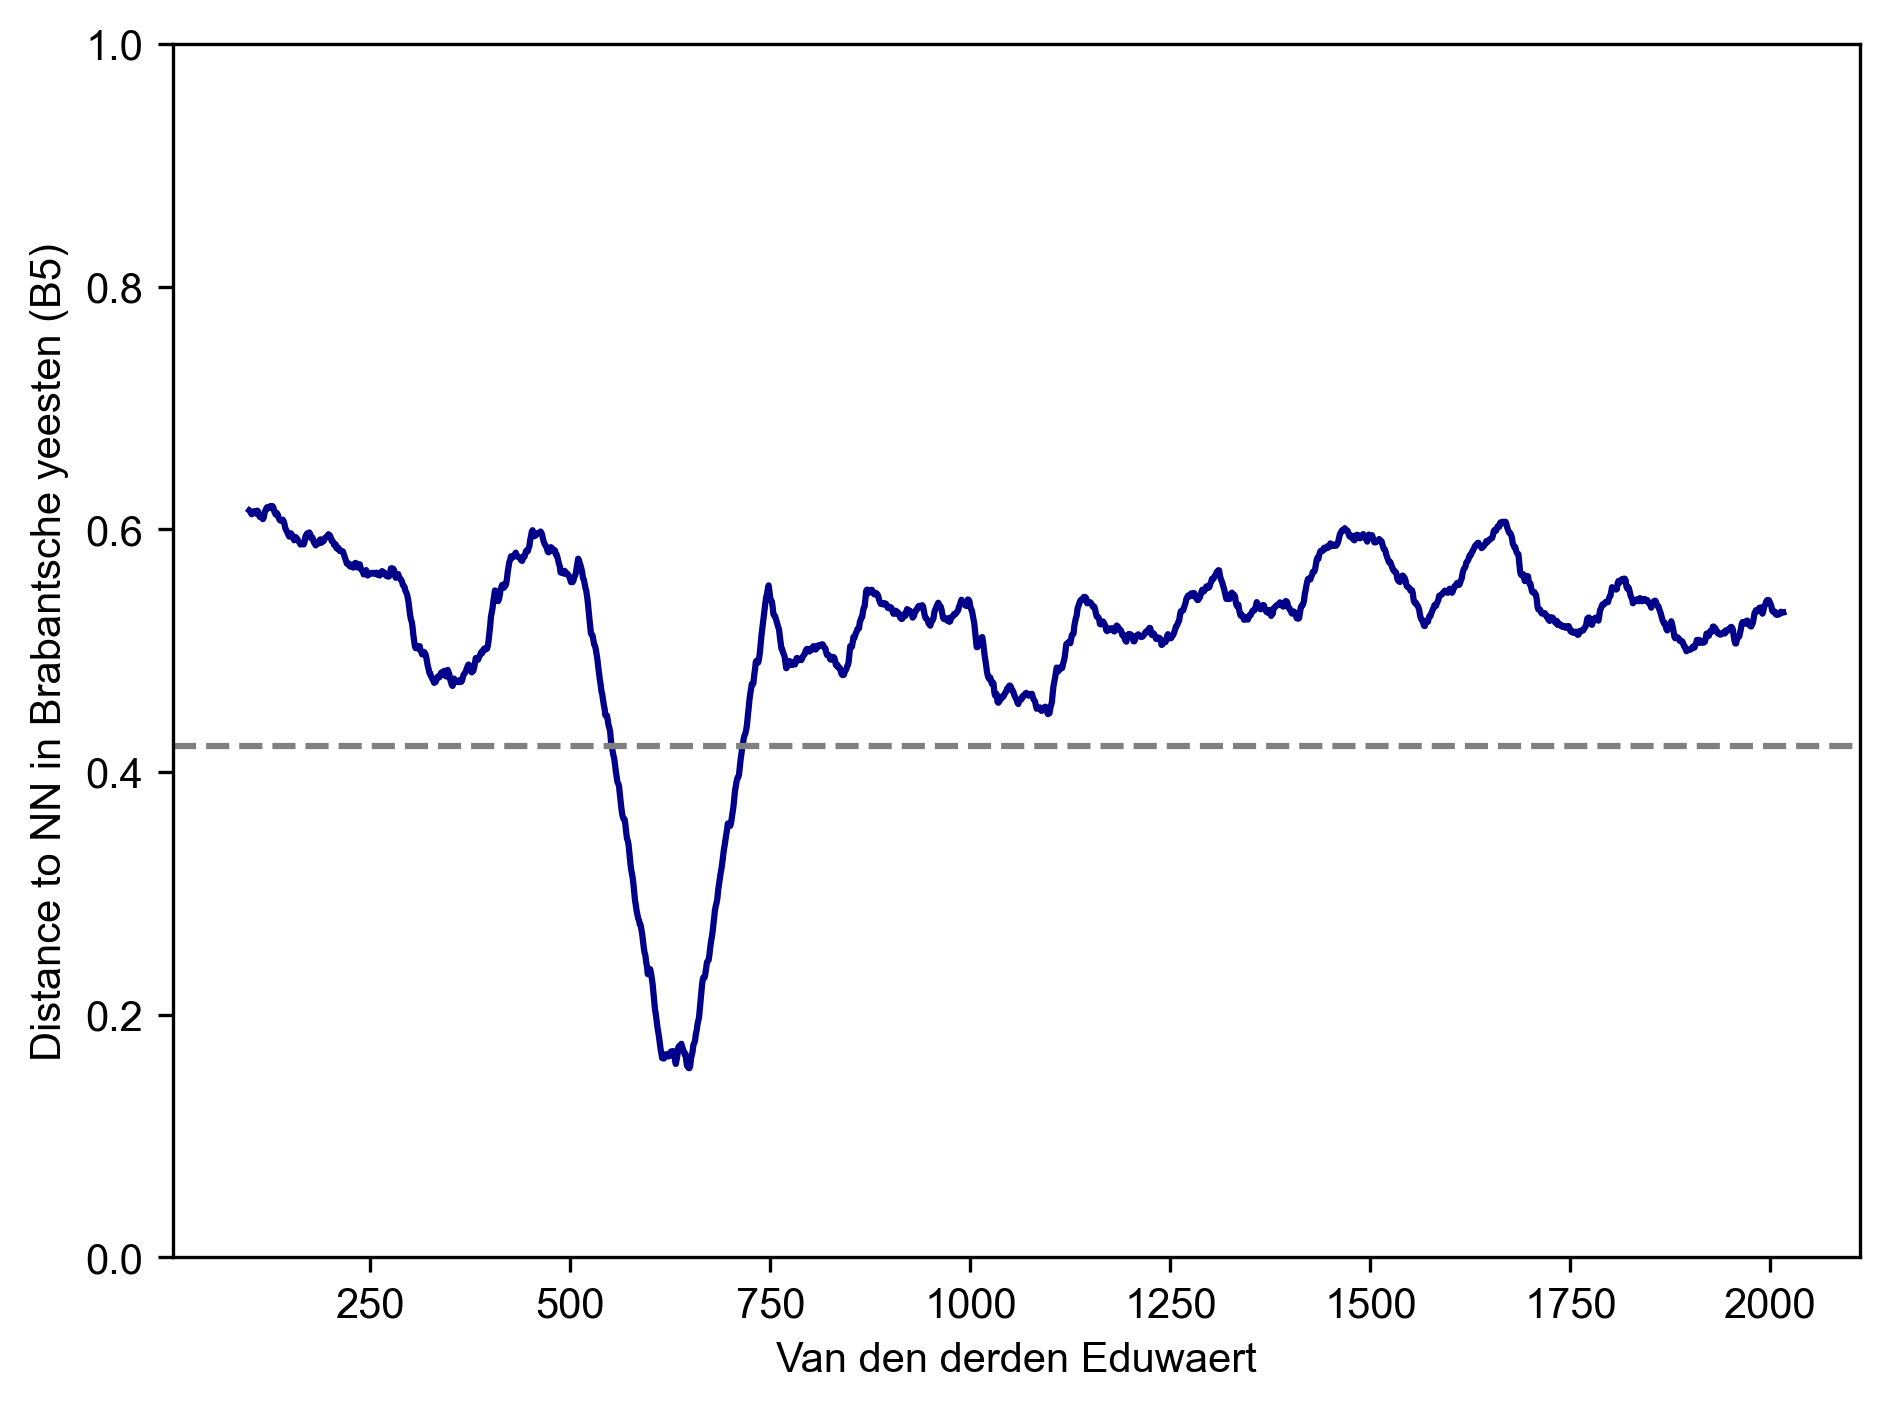

In [20]:
t1, t2 = 'Van den derden Eduwaert', 'Brabantsche yeesten (B5)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)

plt.tight_layout()

In [21]:
get_interpolations('Van den derden Eduwaert') # this part is marked as an interpolation

([[517, 761]], ['BY5'])

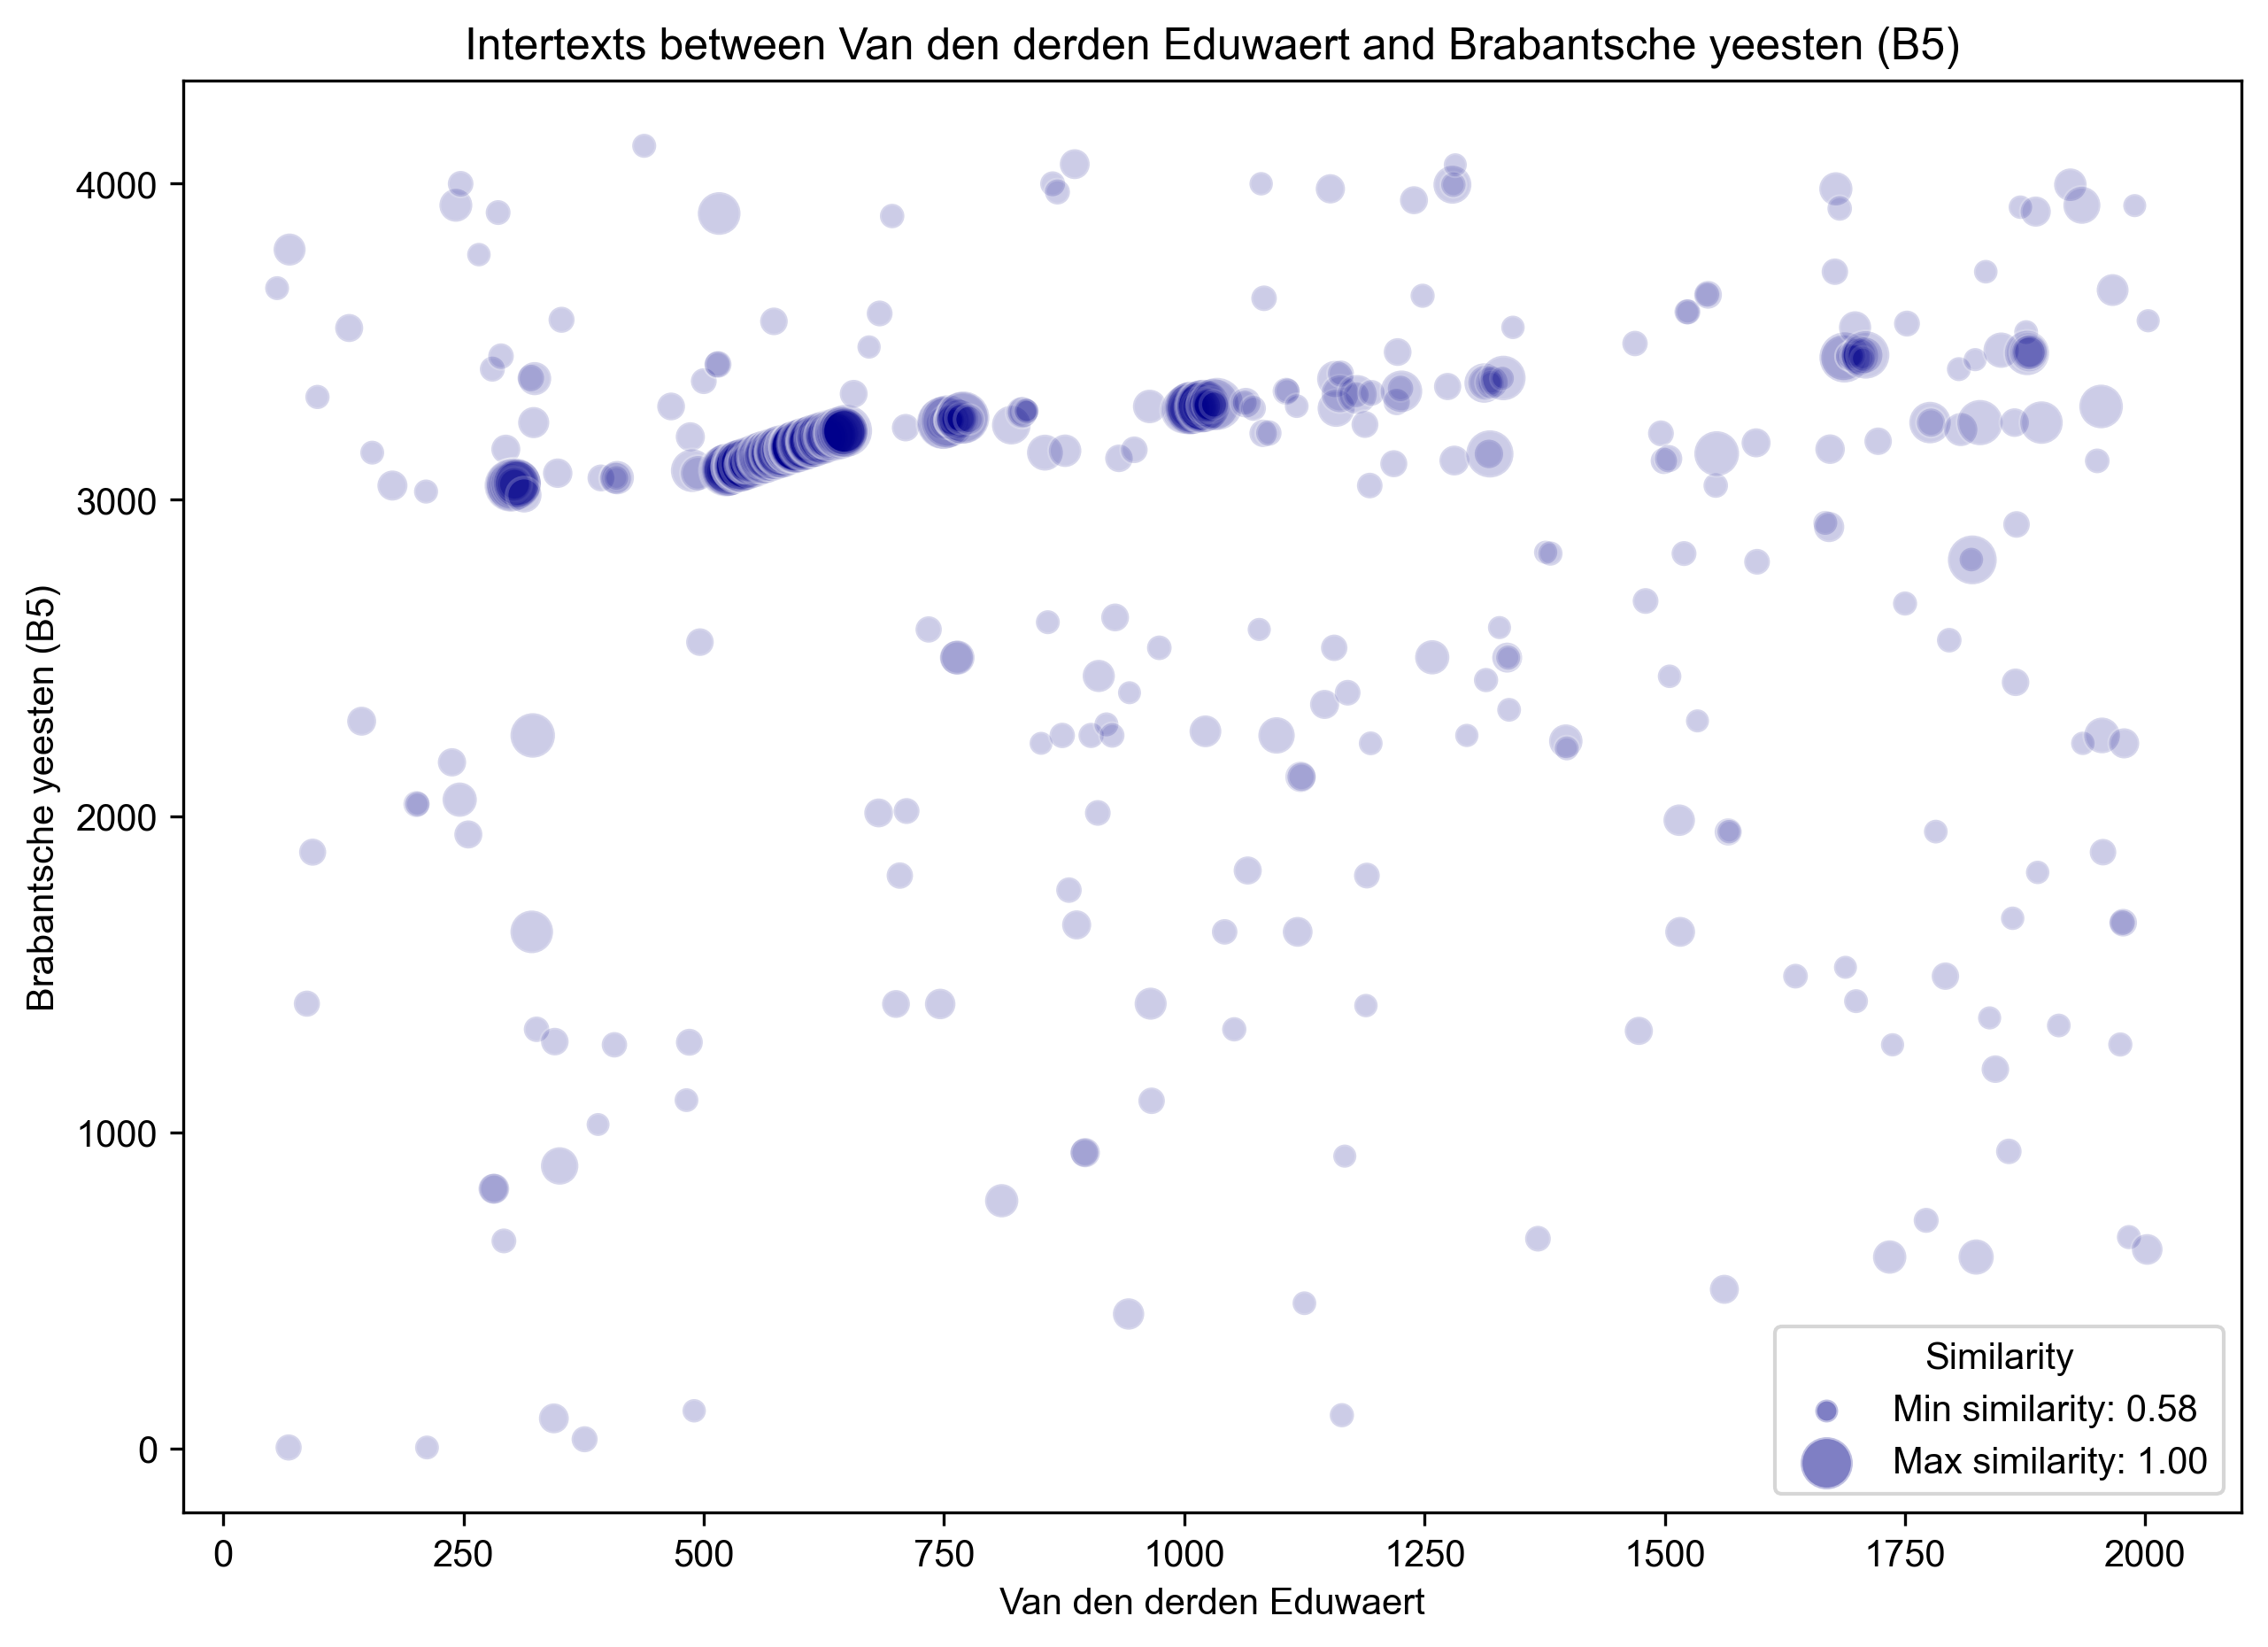

In [22]:
plot_intertexts(t1, t2, distances, threshold=optim_th)

In [23]:
plot_intertexts_interactable(t1, t2, distances, threshold=optim_th)

### Jans teesteye and Boec vander wraken

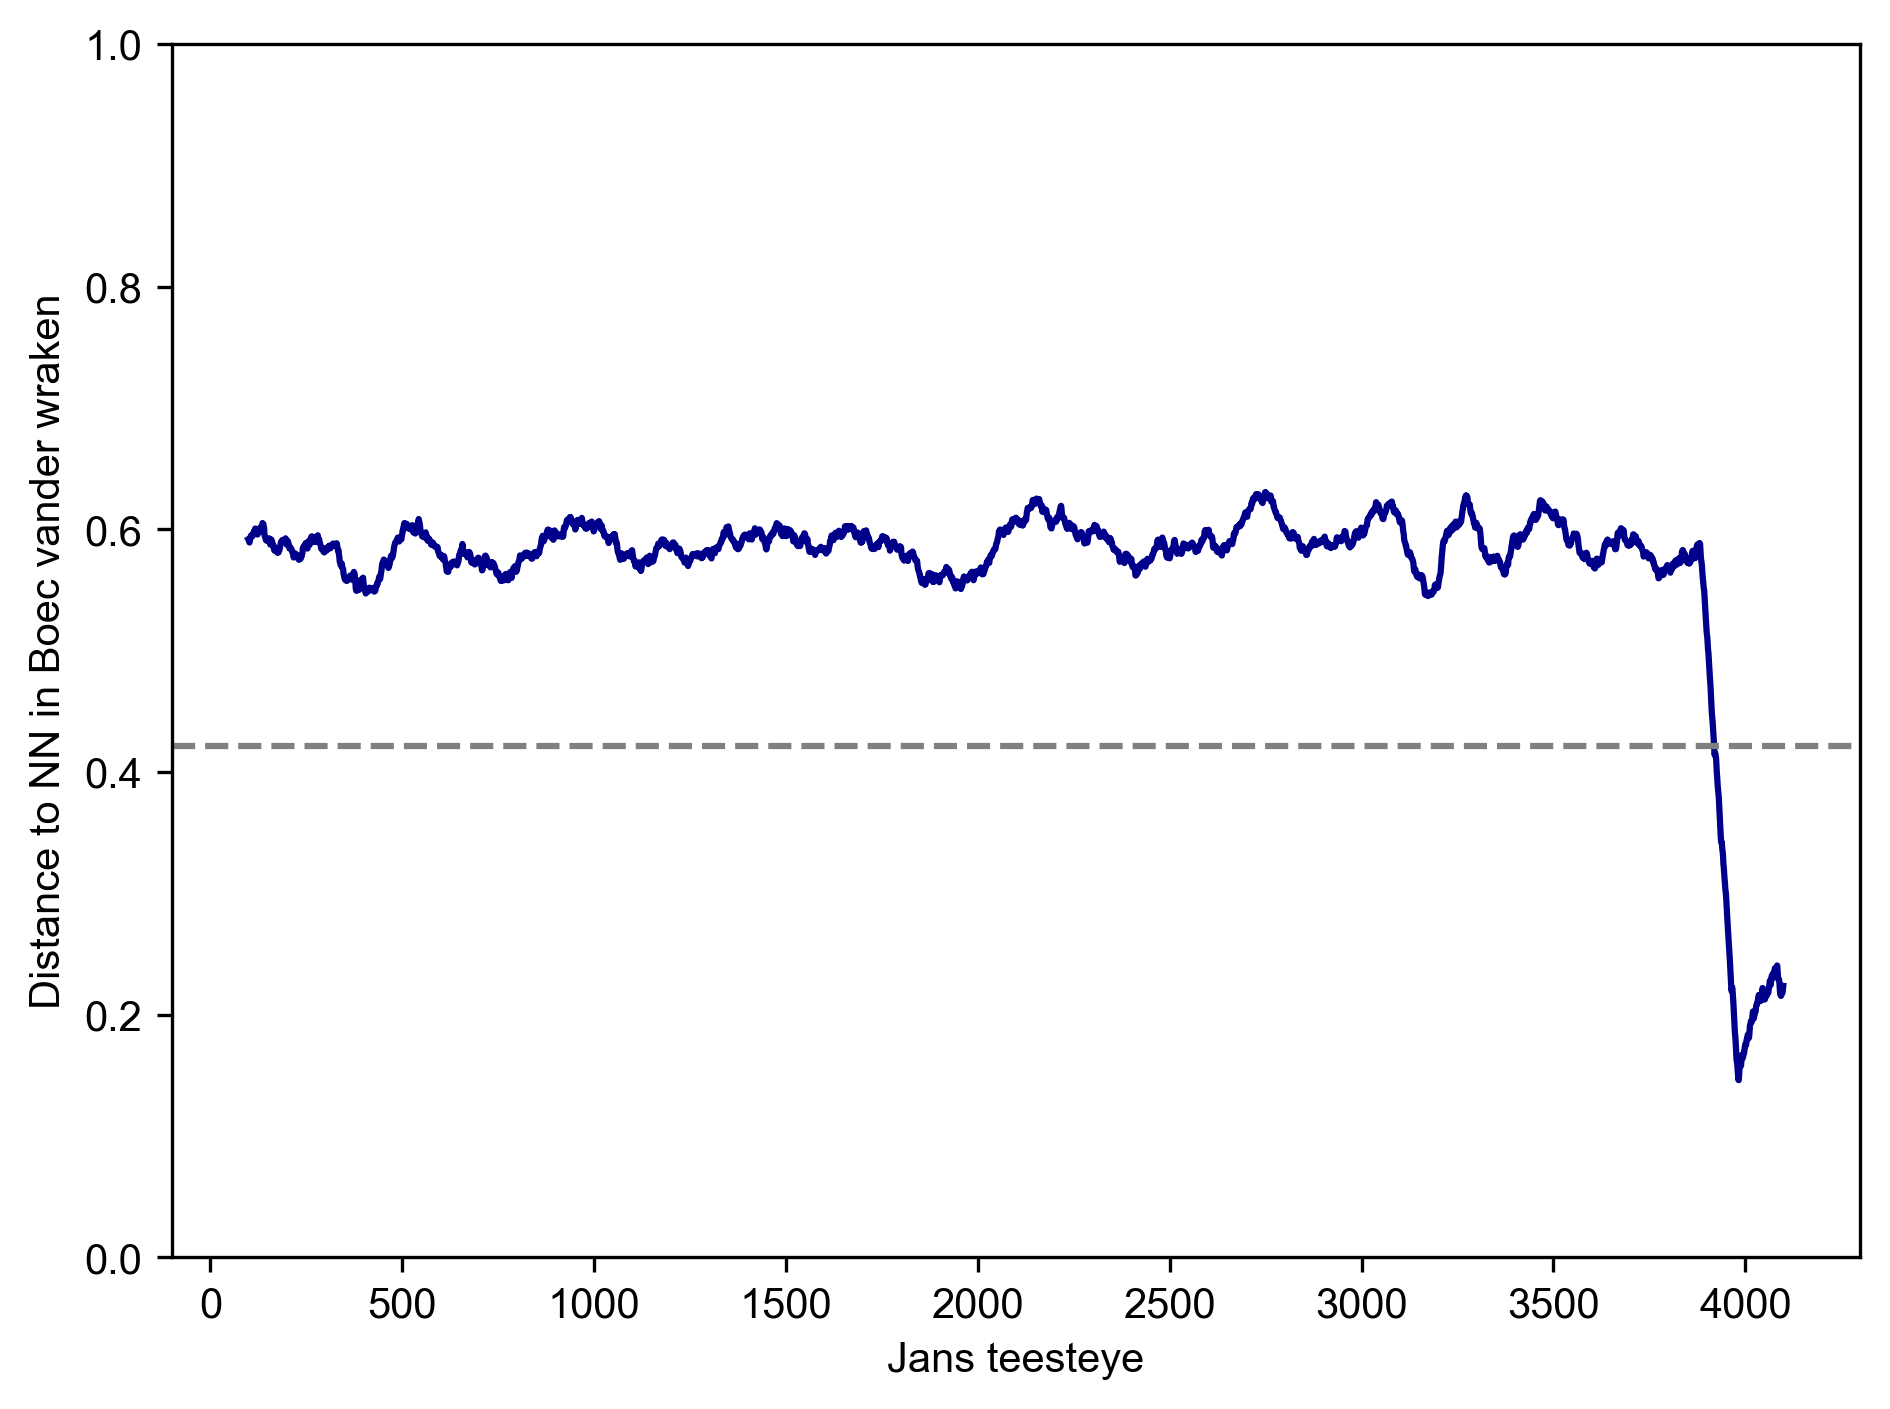

In [24]:
t1, t2 = 'Jans teesteye', 'Boec vander wraken'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)

plt.tight_layout()

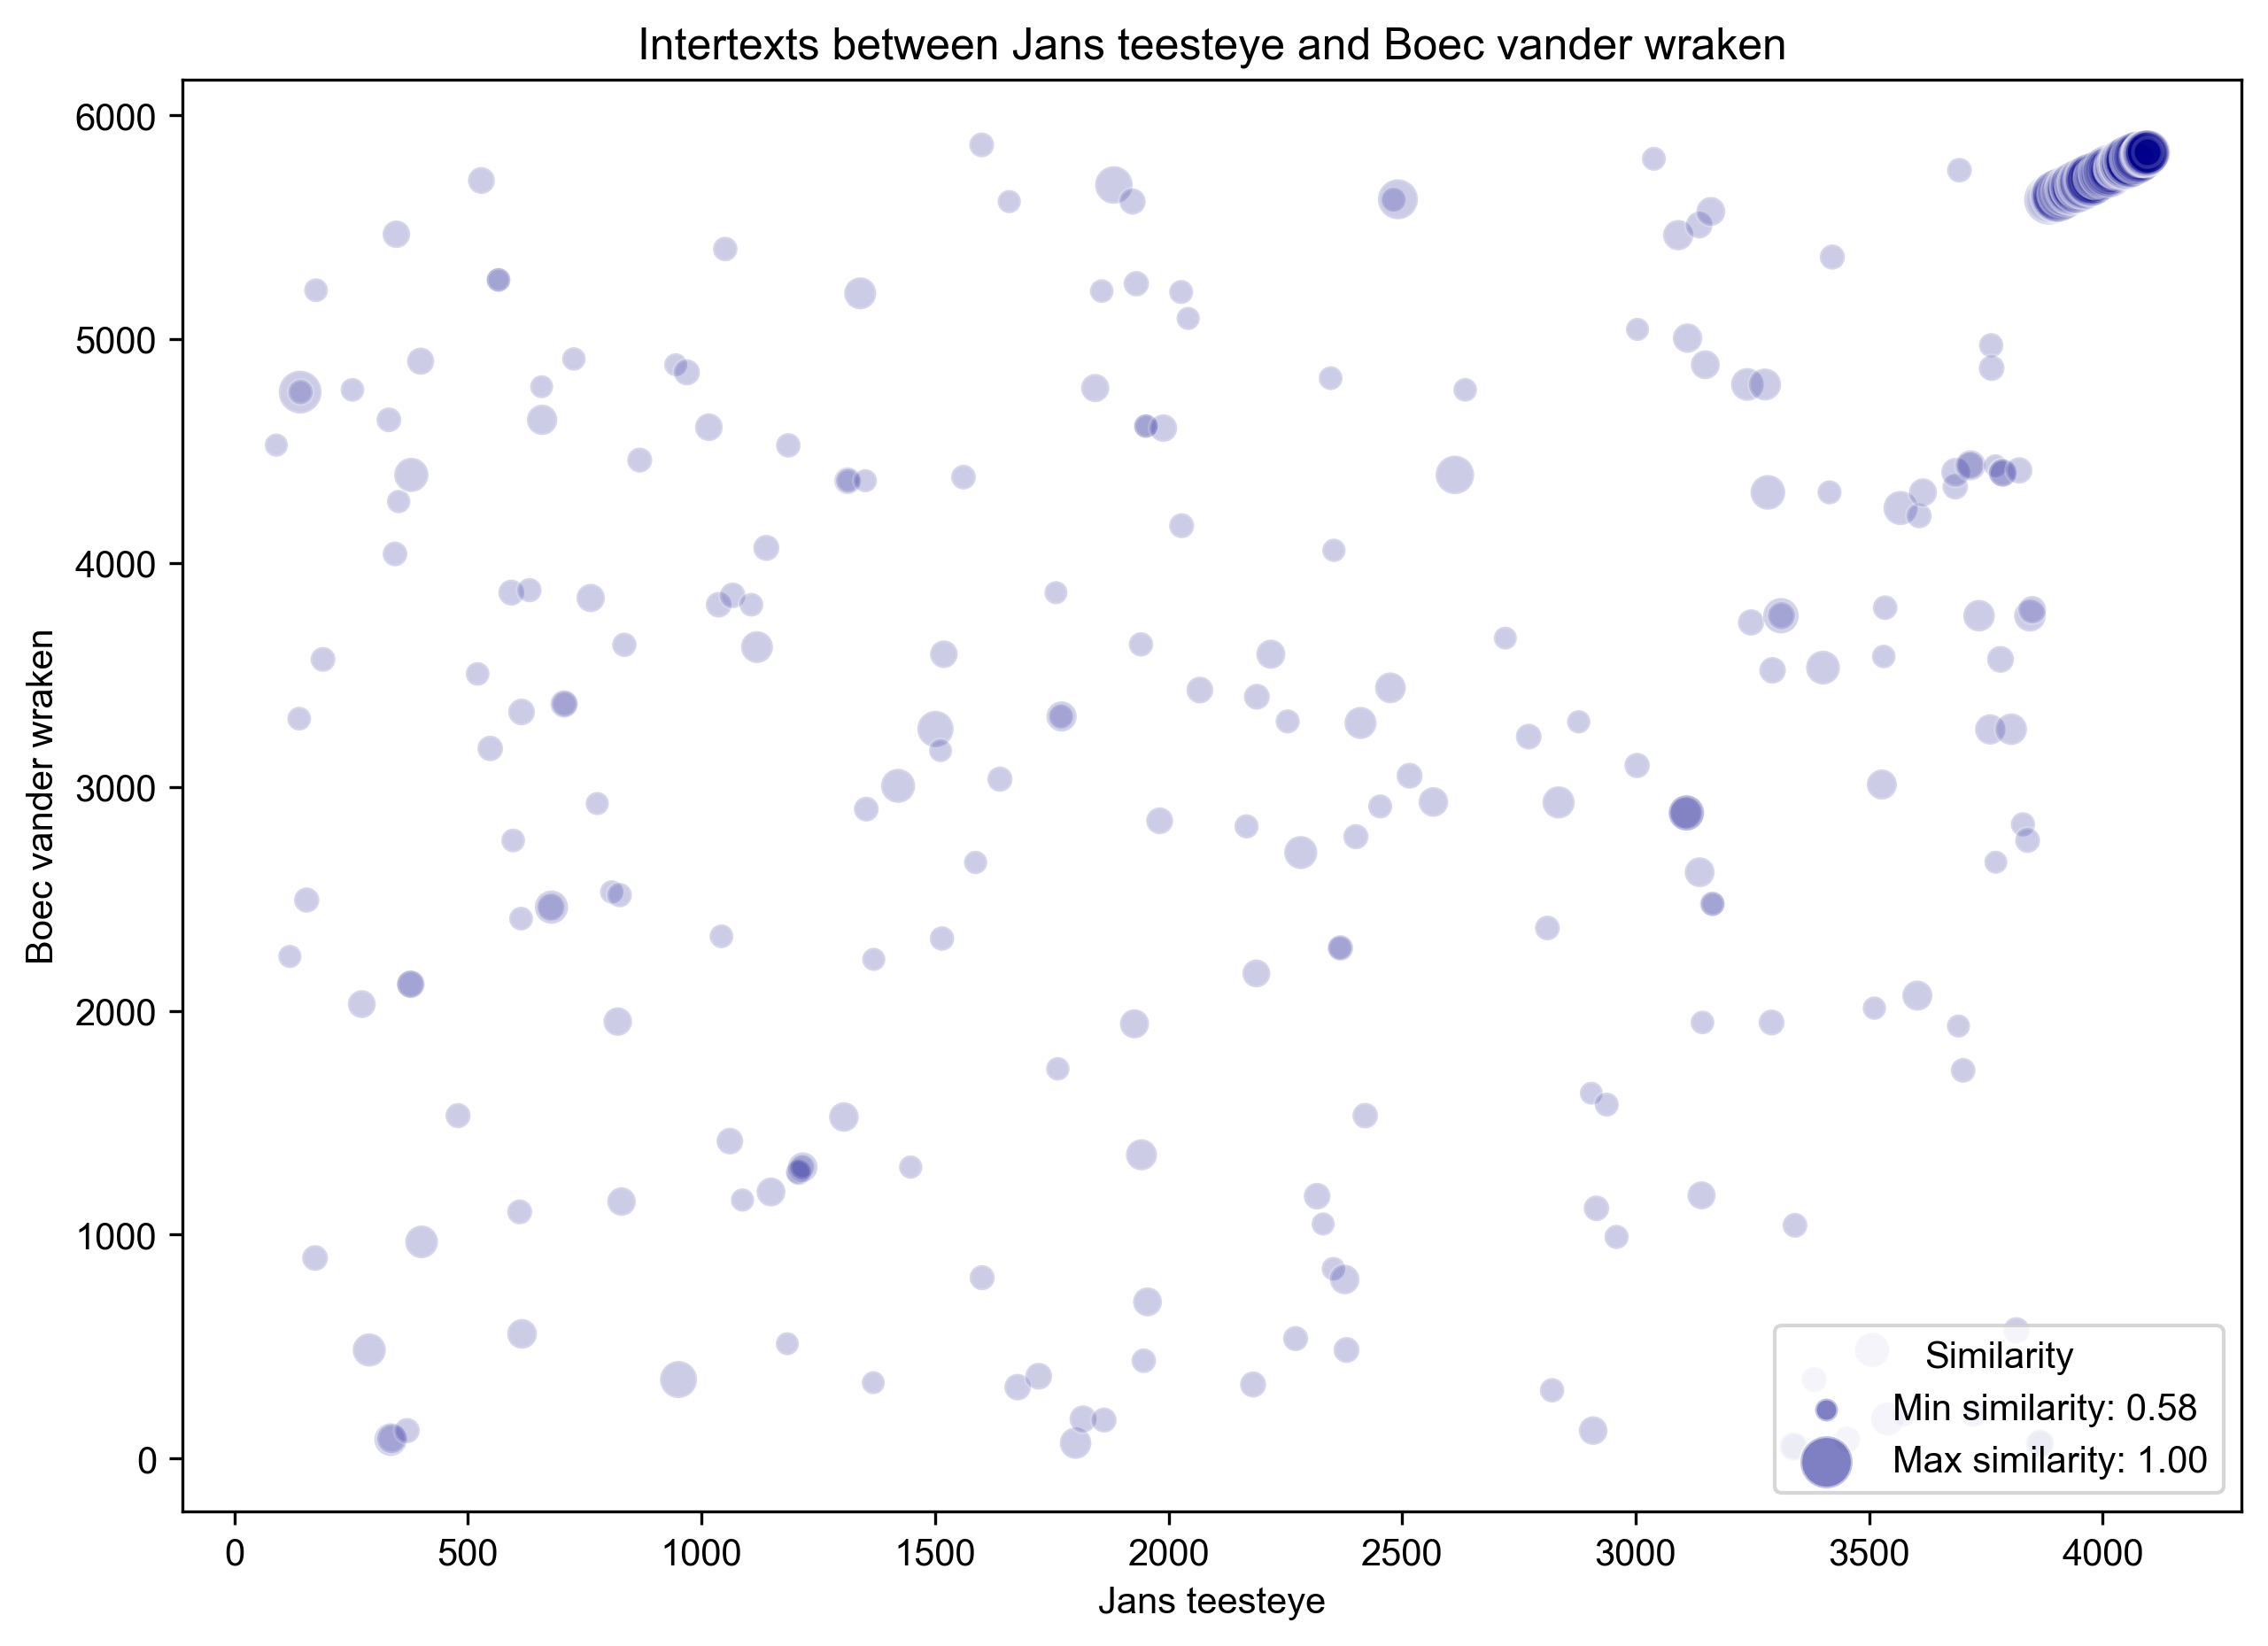

In [25]:
plot_intertexts(t1, t2, distances, threshold=optim_th)

In [26]:
plot_intertexts_interactable(t1, t2, distances, threshold=optim_th)

### Brabantsche yeesten (B1-3) and Korte Kroniek van Brabant (lange versie)

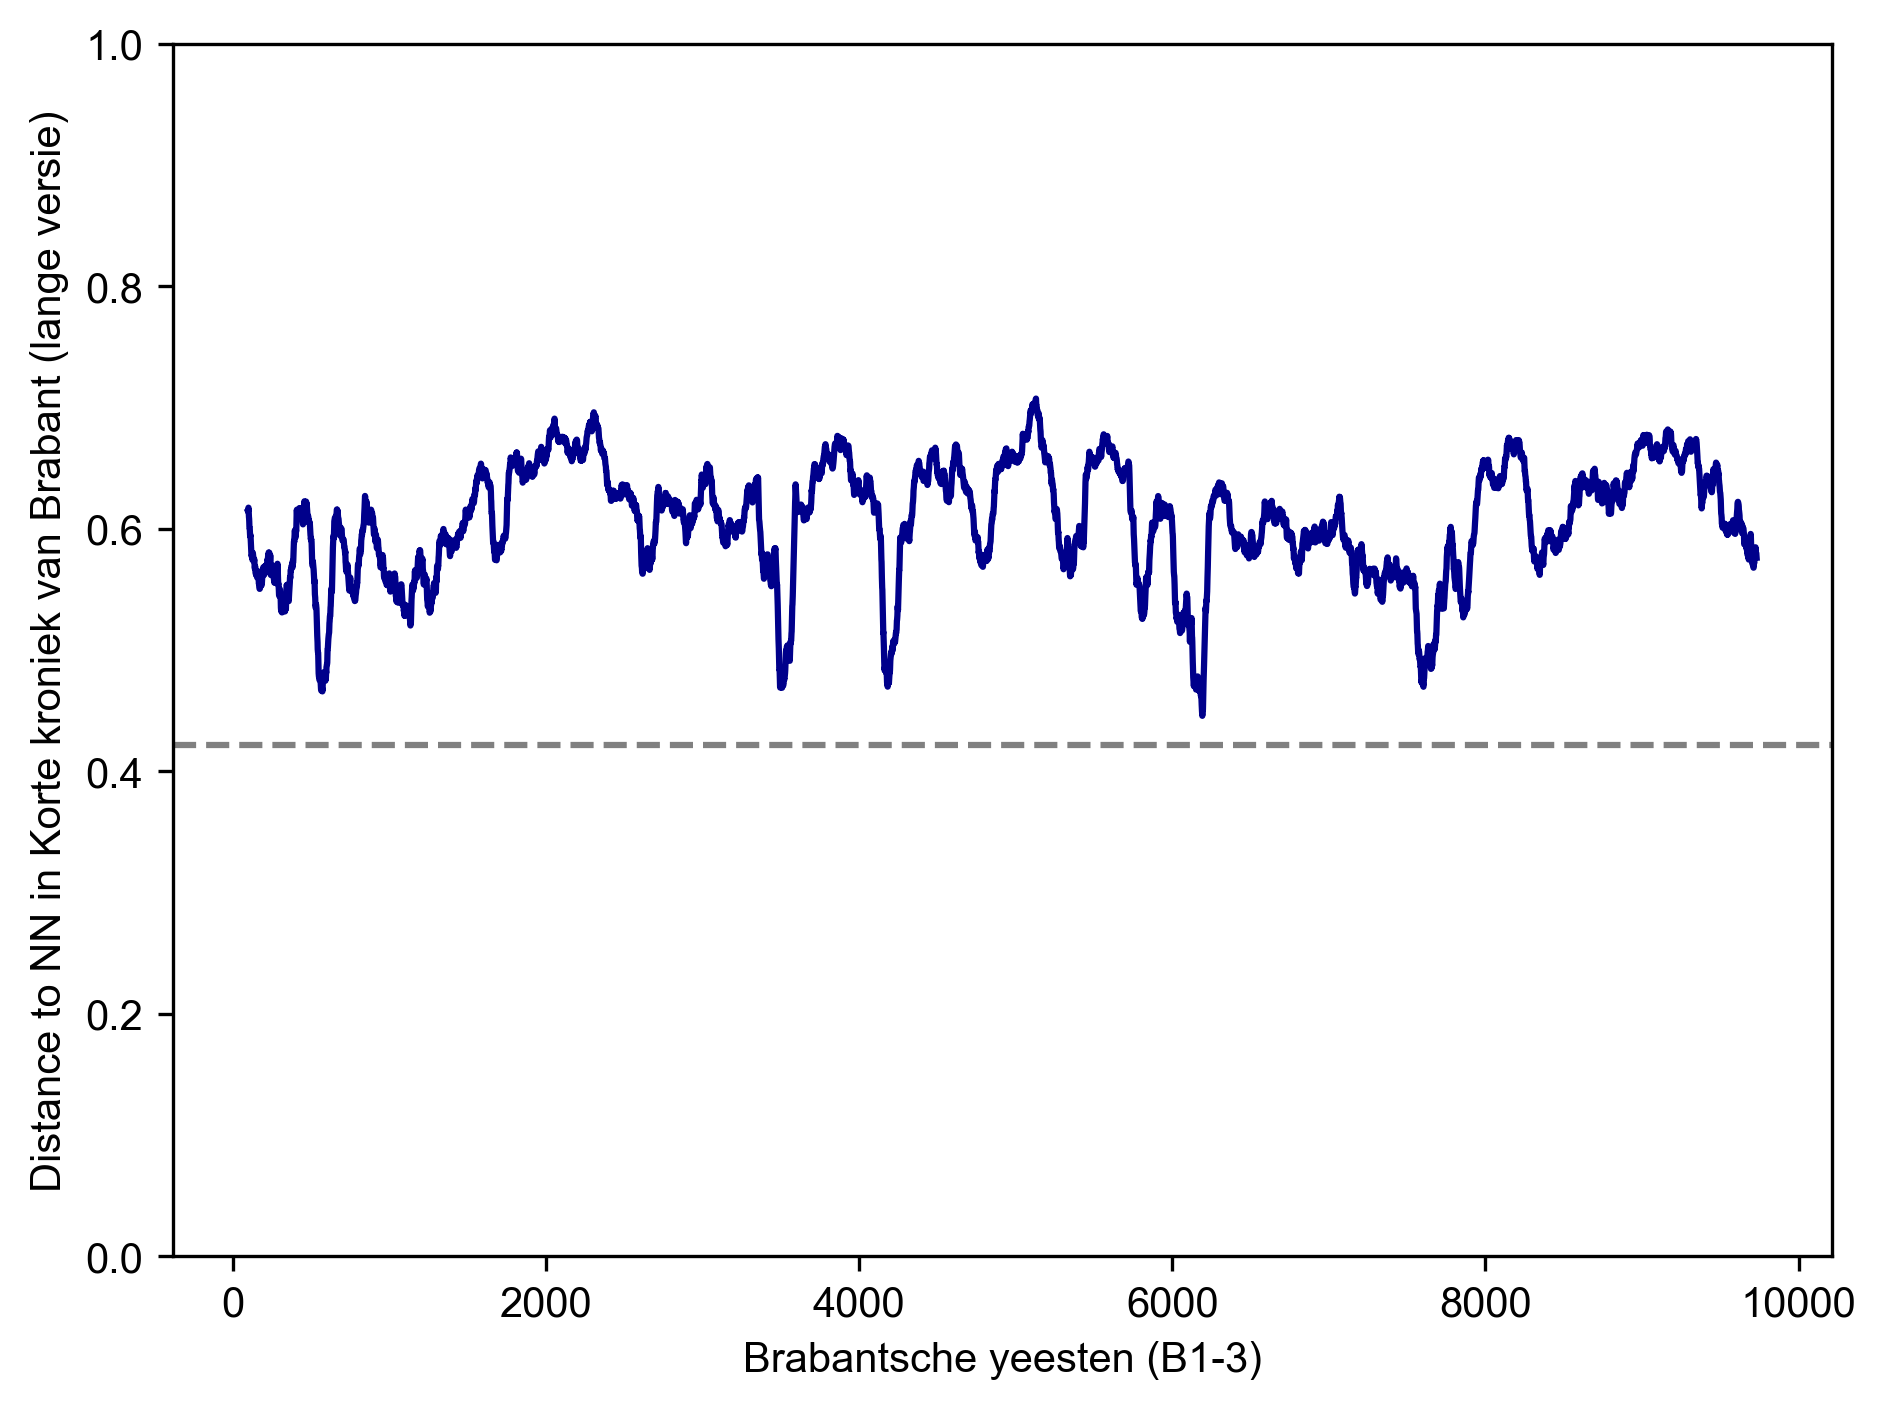

In [27]:
t1, t2 = 'Brabantsche yeesten (B1-3)', 'Korte kroniek van Brabant (lange versie)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)

plt.tight_layout()

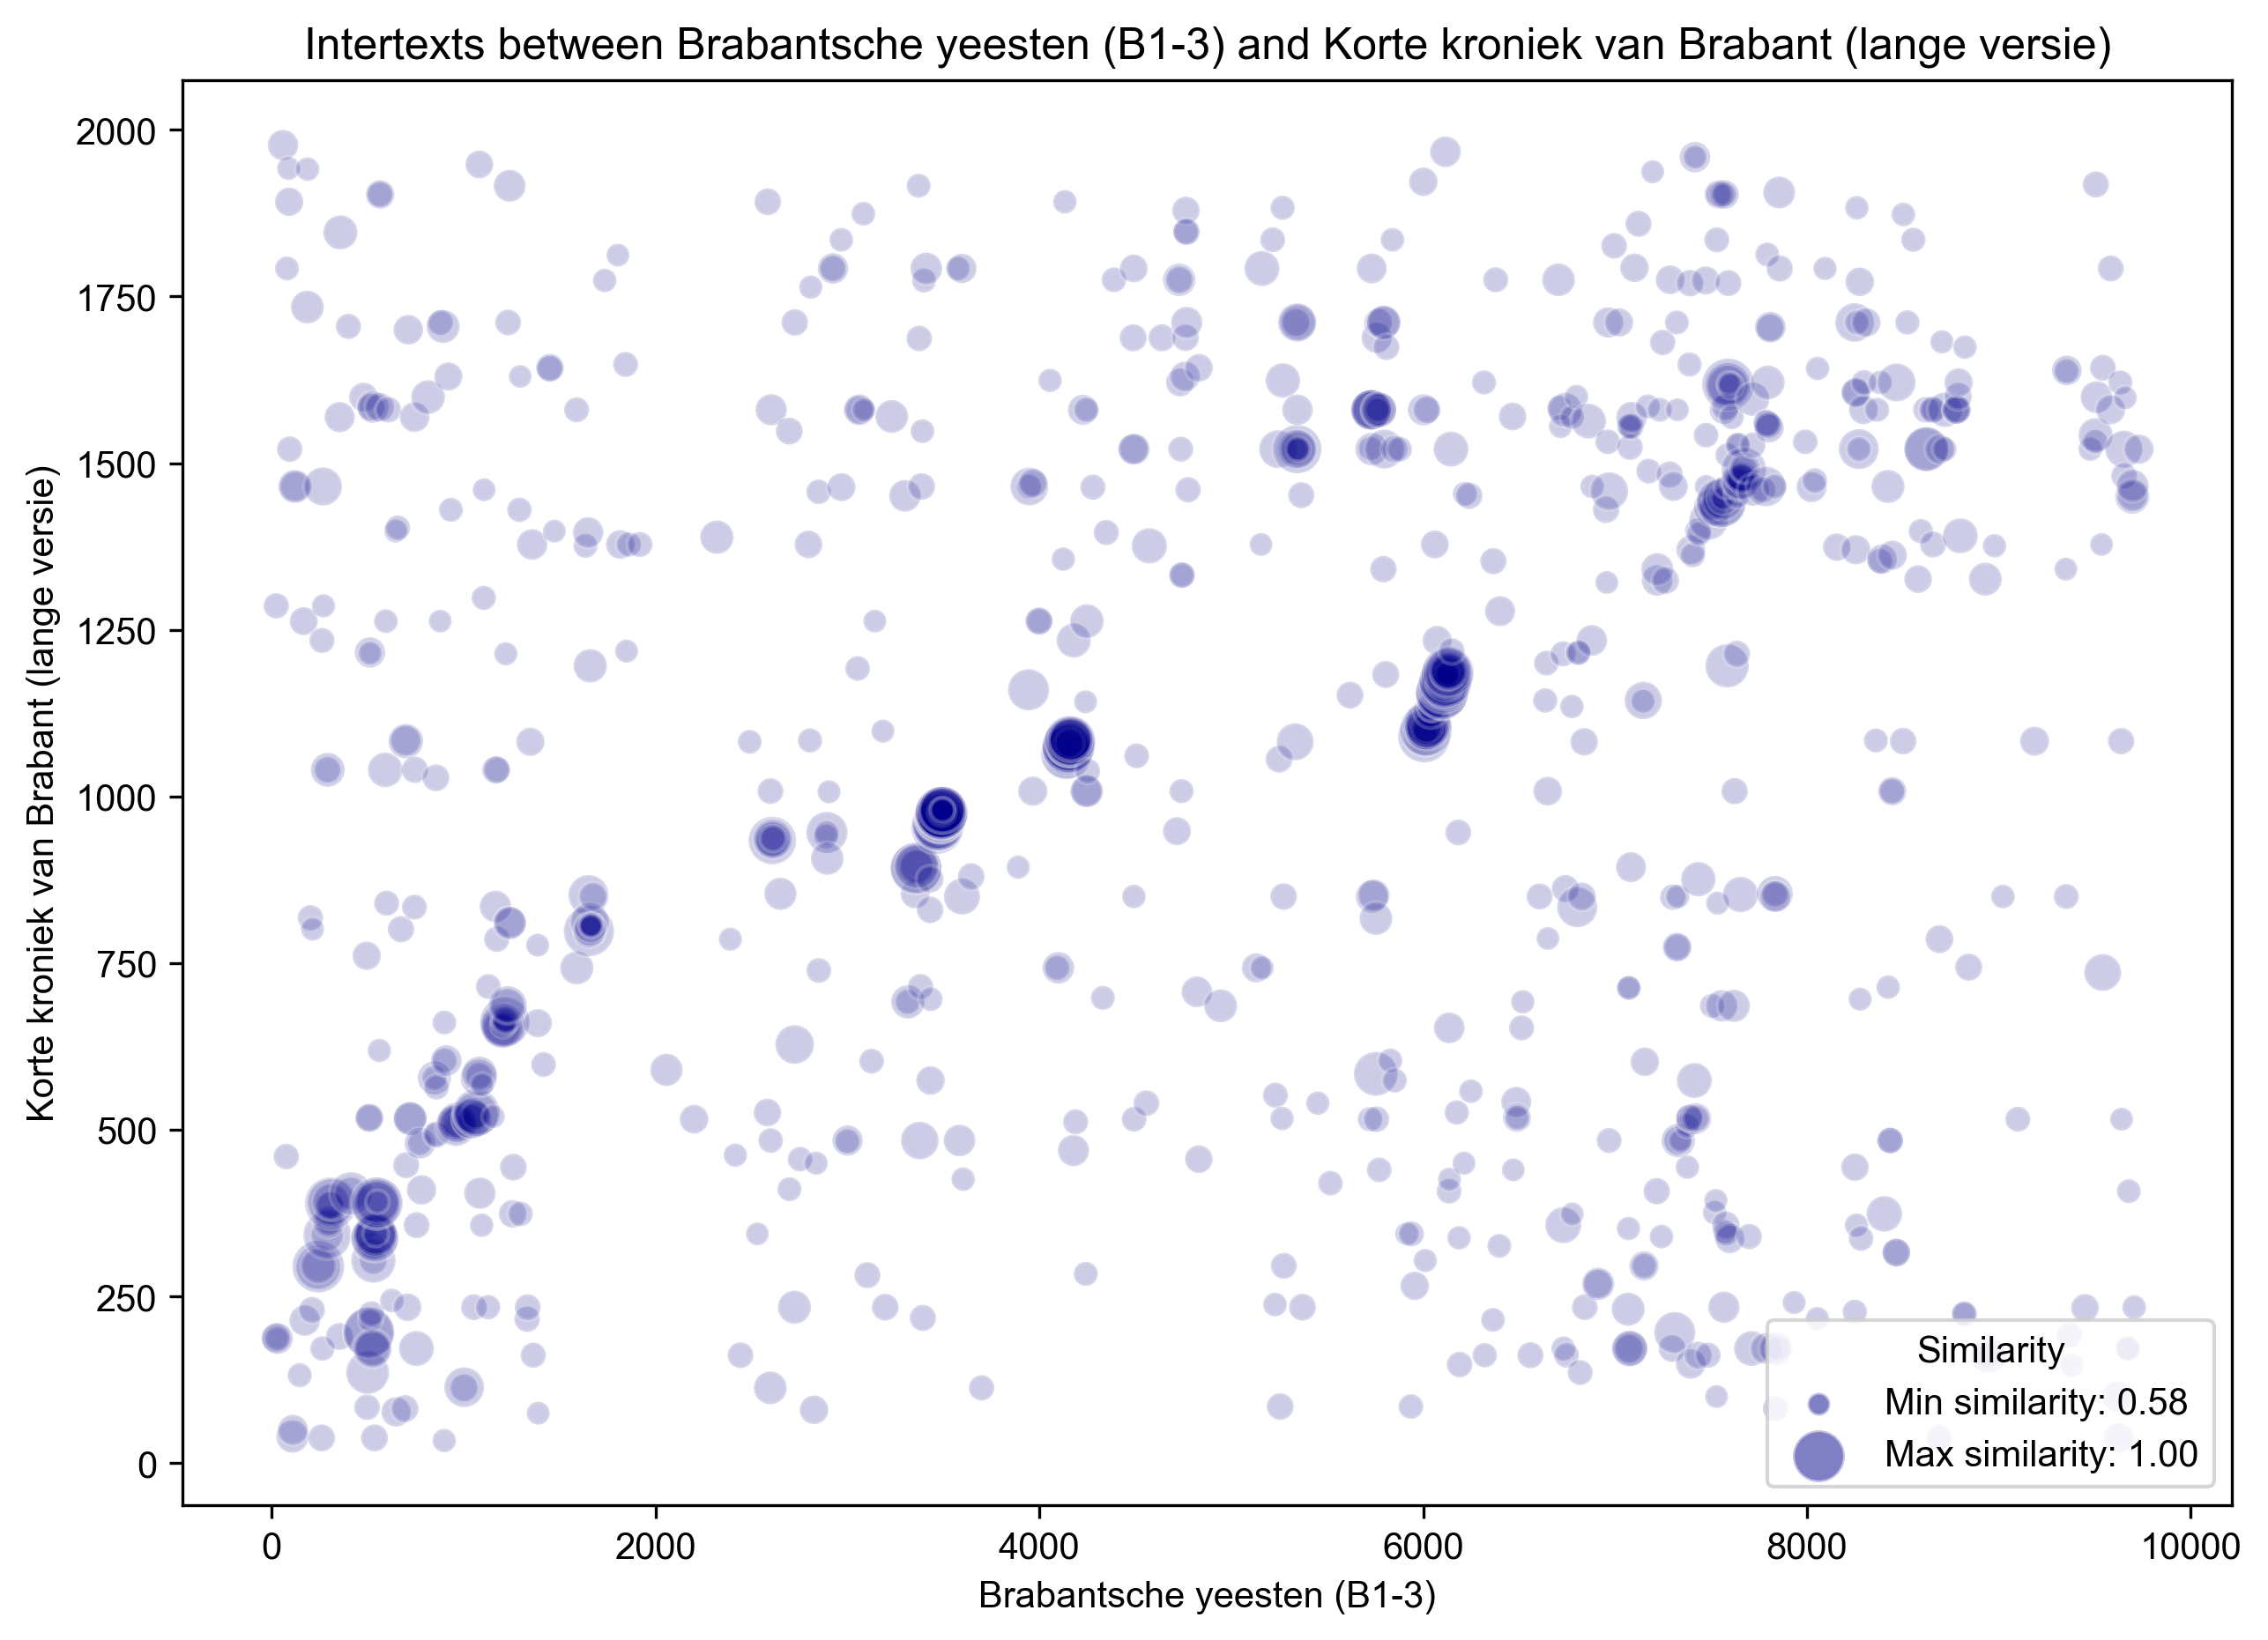

In [28]:
plot_intertexts(t1, t2, distances, threshold=optim_th)

In [29]:
plot_intertexts_interactable(t1, t2, distances, thrseshold=optim_th)

### Vice versa

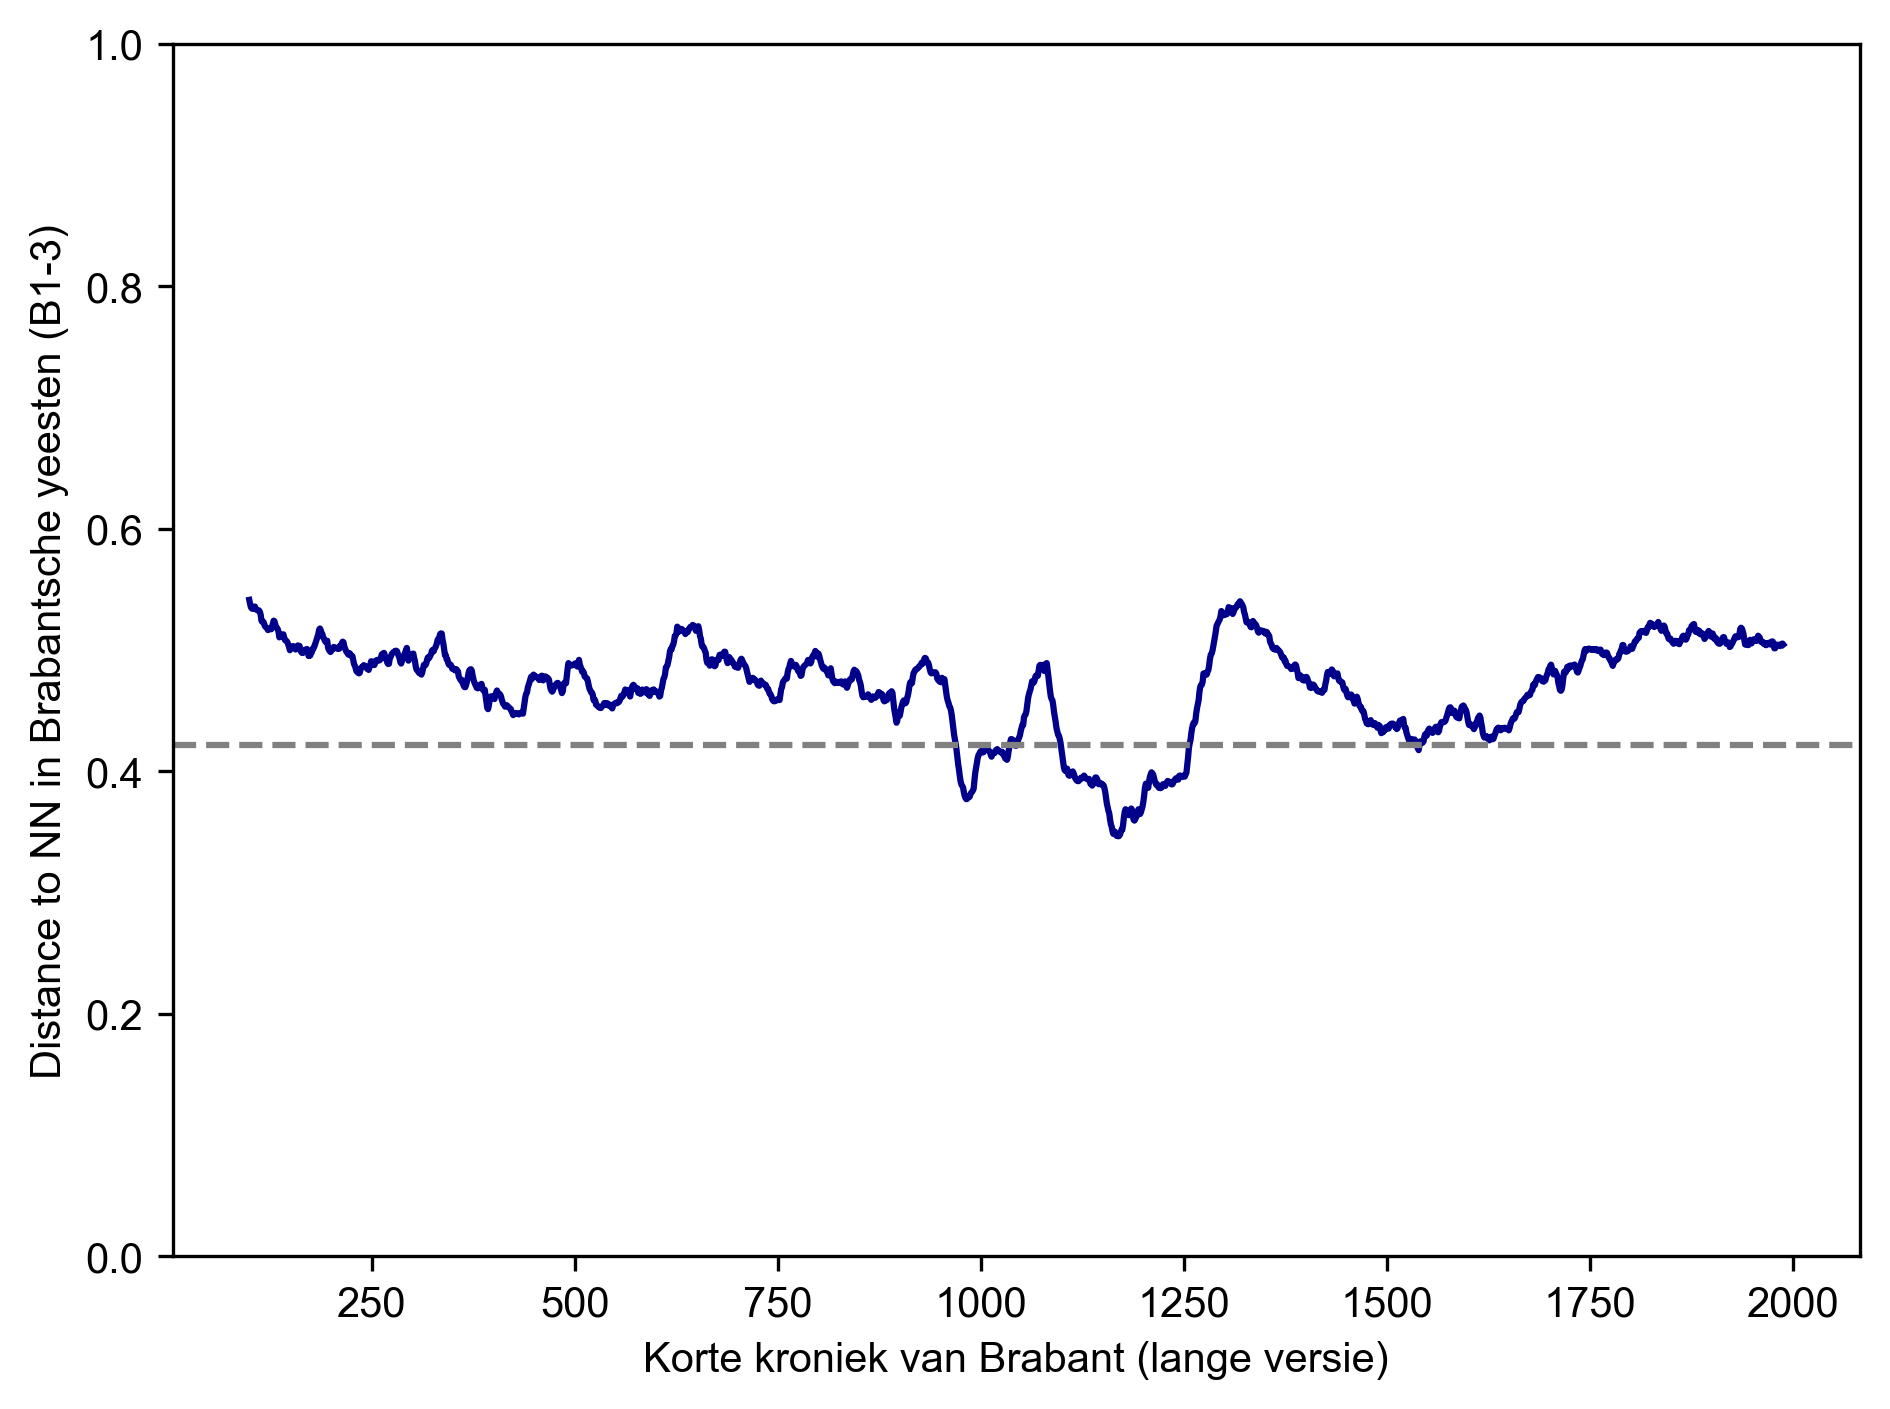

In [30]:
t1, t2 = 'Korte kroniek van Brabant (lange versie)', 'Brabantsche yeesten (B1-3)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)

plt.tight_layout()

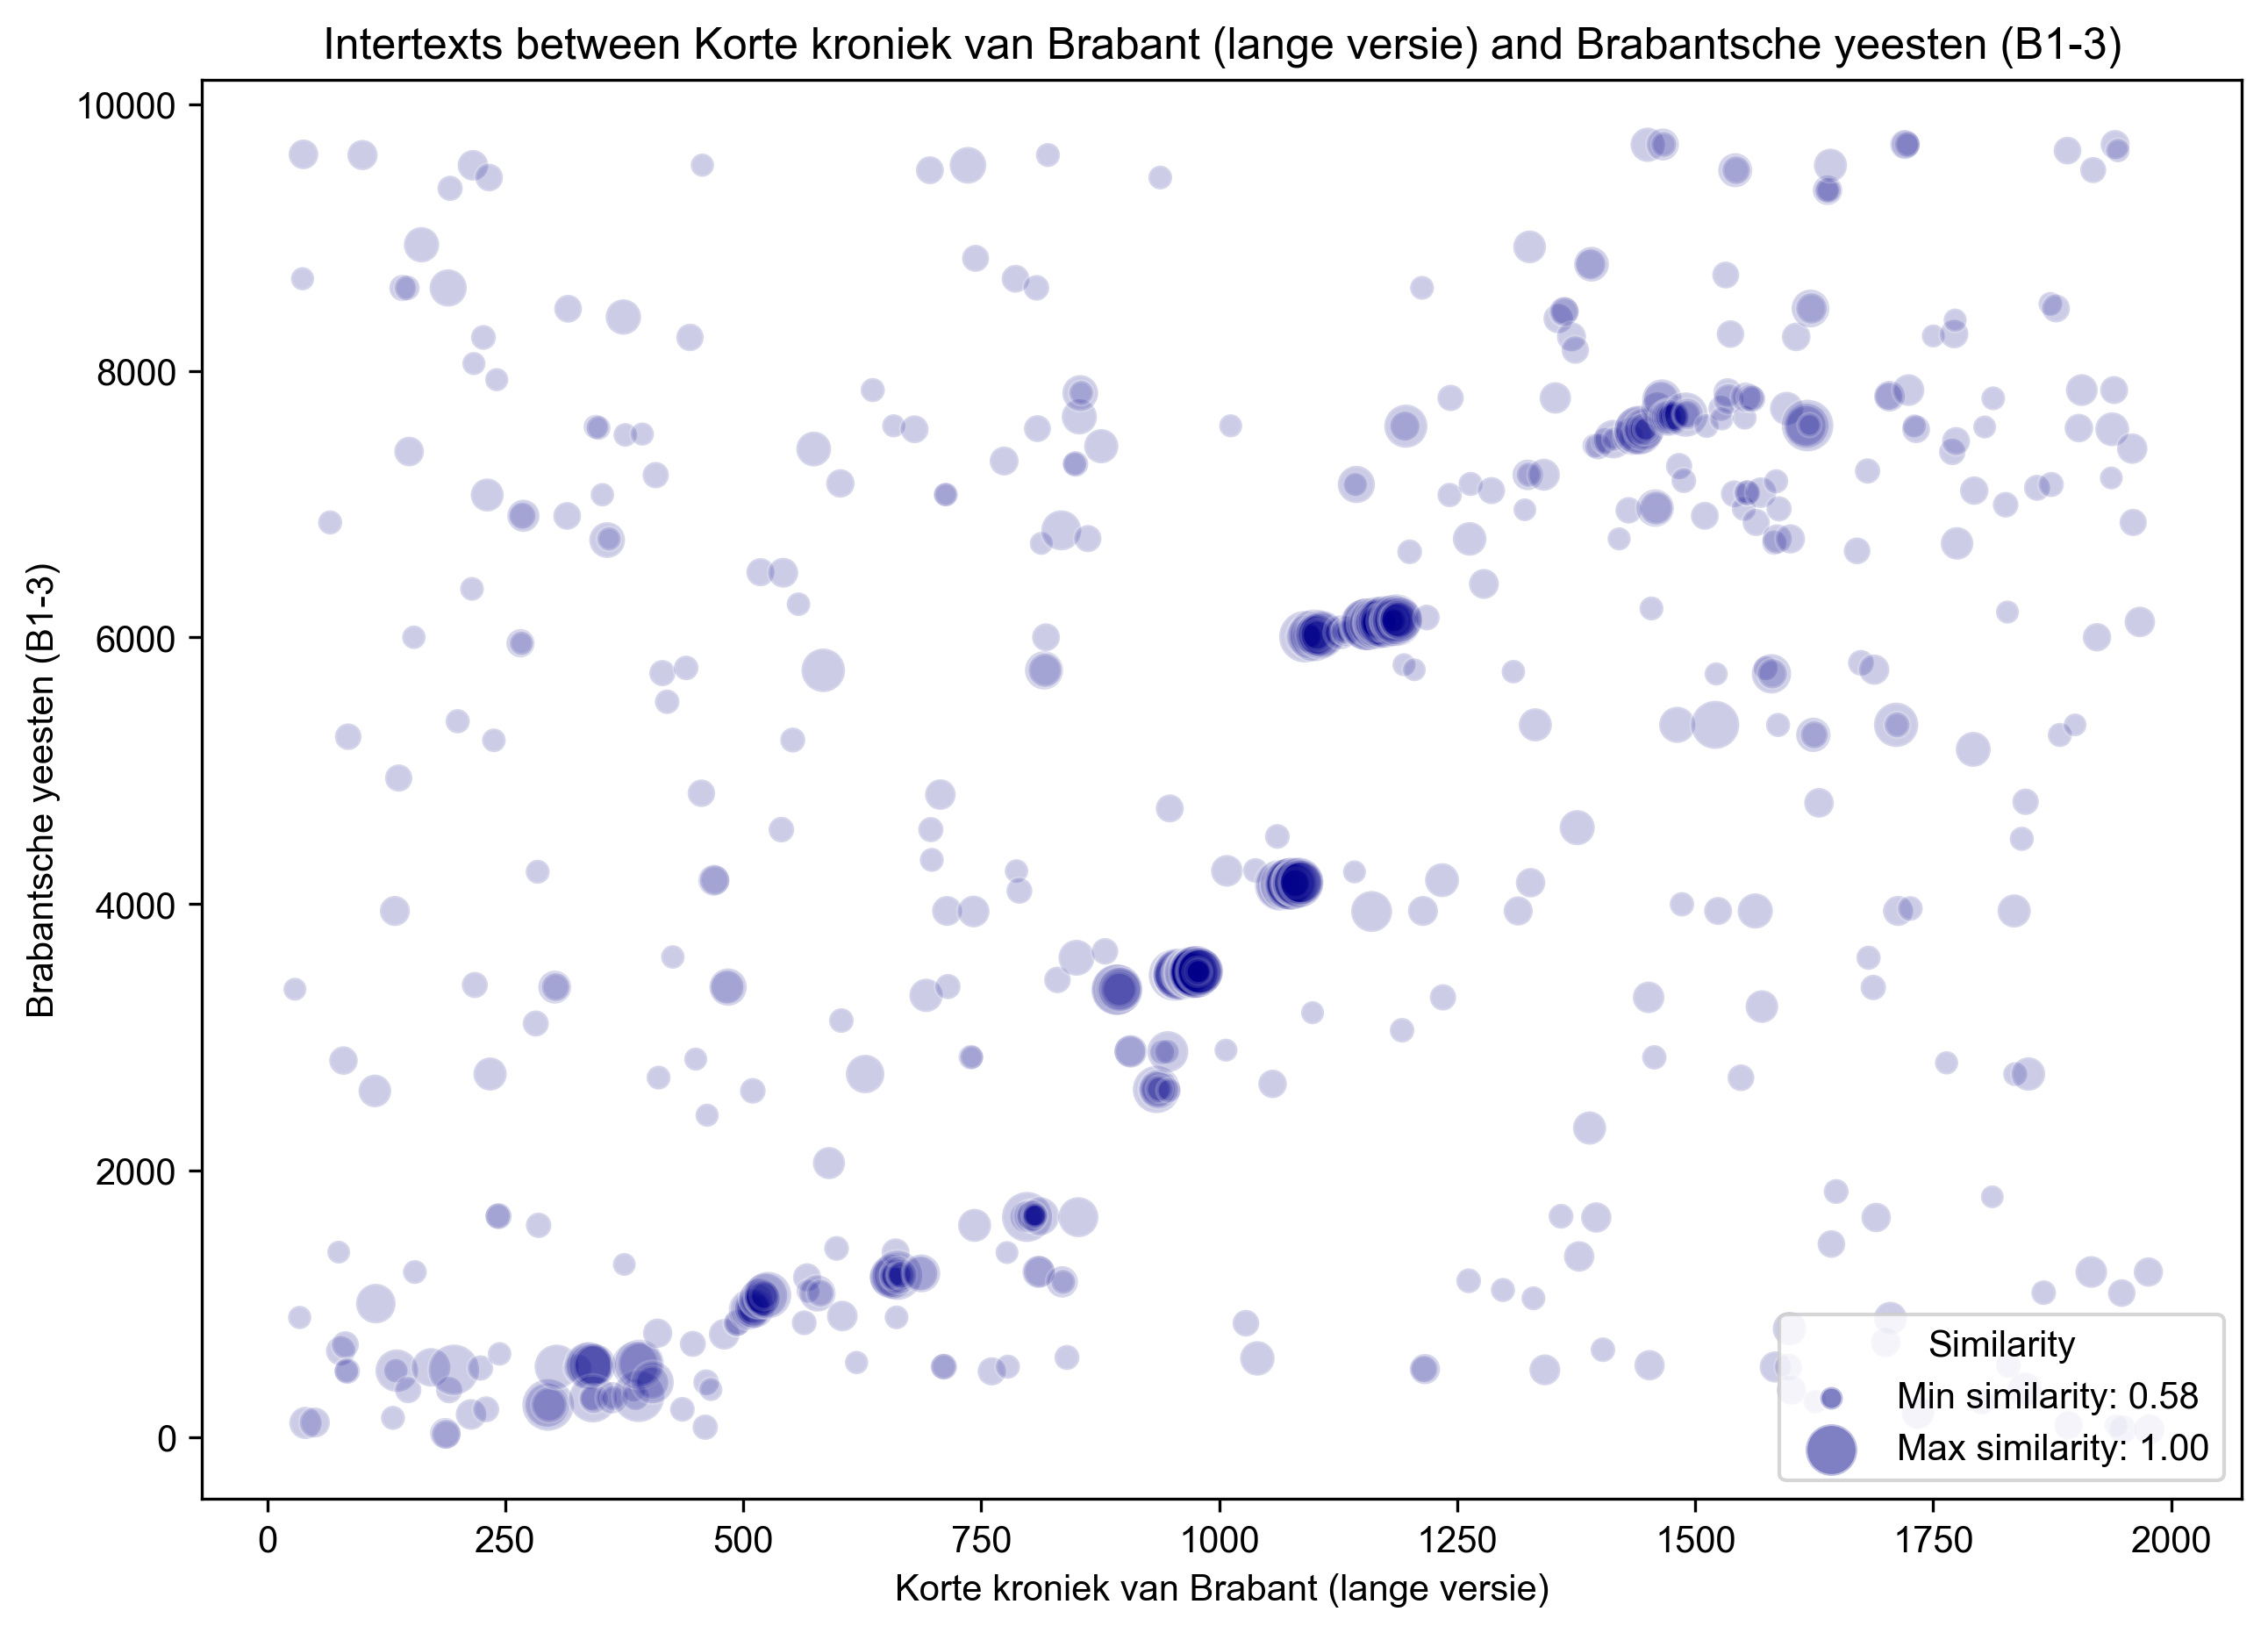

In [31]:
plot_intertexts(t1, t2, distances, threshold=optim_th)

In [32]:
plot_intertexts_interactable(t1, t2, distances, threshold=optim_th)